In [1]:
# Install required libraries
!pip install split-folders
!pip install torchmetrics

In [2]:
# Import Required libraries
import os
import torch
import torchvision
import zipfile
import splitfolders
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import seaborn as sns
from torch.utils.data import random_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from torchmetrics import Accuracy
from torchsummary import summary

In [3]:
# Setting the path to drive. Leave empty if not executed in google colab
path = '/content/drive/MyDrive/Colab Notebooks/'

In [5]:
# Unzipping the dataset
with zipfile.ZipFile(path+'cnn_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('cnn_dataset')

# Checking contents of zip file
os.listdir('cnn_dataset')

['cnn_dataset']

In [6]:
# Splitting images into train, validation and test datasets
splitfolders.ratio("./cnn_dataset/cnn_dataset",seed=1337, output="cnn-splitted", ratio=(0.7, 0.15, 0.15))

Copying files: 100800 files [00:14, 6996.29 files/s]


In [4]:
# set the path of directory containing train,test and validation sets
data_path = "./cnn-splitted"

In [5]:
# Get train, test and validation image datasets
from torchvision.datasets import ImageFolder
import torch.utils.data
from torchvision import transforms

# Transform images to tensors
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Get image datasets and transform them to tensors
train_dataset = ImageFolder(data_path+'/train', transform=transform)
test_dataset = ImageFolder(data_path+'/test', transform=transform)
val_dataset = ImageFolder(data_path+'/val', transform=transform)

# Get the classes of dataset
classes = train_dataset.classes
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [6]:
# Load train, test and validation image datasets
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

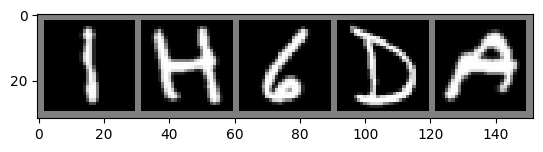

1     H     6     D     A    


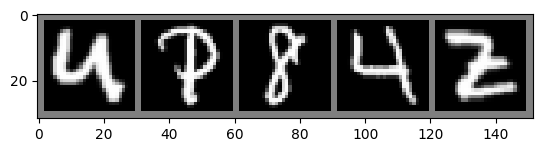

U     P     8     4     Z    


In [7]:
# Plotting sample images

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:5]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

# Show images
imshow(torchvision.utils.make_grid(images[5:10]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5, 10)))

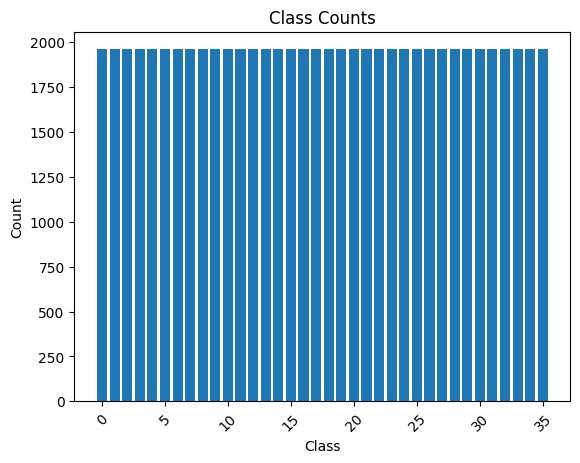

In [39]:
# Plotting Class Distribution

class_counts = {}

for images, labels in train_loader:

    labels = labels.numpy()
    # Get all unique labels and their counts
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    # Update count
    for label, count in zip(unique_labels, label_counts):
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += count

# Sort counts by classes
sorted_class_counts = {k: v for k, v in sorted(class_counts.items())}


class_labels = list(sorted_class_counts.keys())
class_counts = list(sorted_class_counts.values())
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Counts')
plt.xticks(rotation=45)
plt.show()

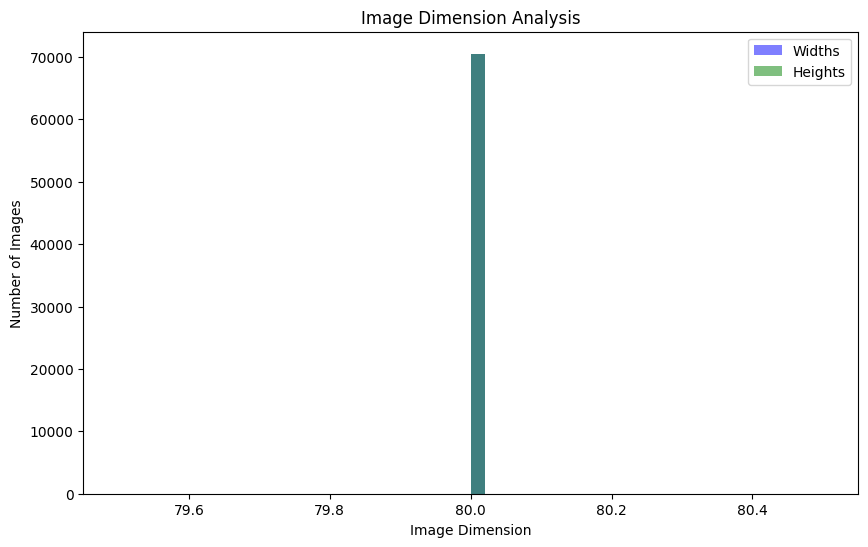

In [40]:
# Plot image Dimensions

image_dimensions = []

for images, labels in train_loader:

    images = images.numpy()
    # Calculate image dimensions
    dimensions = [(image.shape[1], image.shape[2]) for image in images]

    image_dimensions.extend(dimensions)

# Create a histogram of image sizes
widths = [size[0] for size in image_dimensions]
heights = [size[1] for size in image_dimensions]

plt.figure(figsize=(10, 6))
plt.hist(widths, bins=50, alpha=0.5, label='Widths', color='blue')
plt.hist(heights, bins=50, alpha=0.5, label='Heights', color='green')
plt.xlabel('Image Dimension')
plt.ylabel('Number of Images')
plt.title('Image Dimension Analysis')
plt.legend()
plt.show()

**Inspired from AlexNet Architecture**

In [8]:
# CNN architecture

class CNN(nn.Module):
    def __init__(self, dp = 0.5, activation_function = nn.ReLU()):
        super().__init__()

        # Block-1
        '''
        Since the image input is of size 28*28*3,
        the output of conv1 will be of size = 26*26*96
        '''
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding=0)
        self.norm1 = nn.BatchNorm2d(96)
        self.relu1 = activation_function
        '''
        The output of maxpool1 will be of size = 13*13*96
        '''
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Block-2
        '''
        The output of conv2 will be of size = 13*13*256
        '''
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(256)
        self.relu2 = activation_function
        '''
        The output of maxpool2 will be of size = 6*6*6256
        '''
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Block-3
        '''
        The output of conv3 will be of size = 6*6*384
        '''
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm2d(384)
        self.relu3 = activation_function

        # Block-4
        '''
        The output of conv4 will be of size = 6*6*384
        '''
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.norm4 = nn.BatchNorm2d(384)
        self.relu4 = activation_function

        # Block-5
        '''
        The output of conv5 will be of size = 6*6*256
        '''
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.norm5 = nn.BatchNorm2d(256)
        self.relu5 = activation_function
        '''
        The output of maxpool-3 will be 5*5*256
        '''
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)

        # FC-1
        '''
        5*5*256 is output of above layer
        4096 is random number of neurons we want to produce
        '''
        self.fc1 = nn.Linear(5 * 5 * 256, 4096)
        self.relu6 = activation_function
        self.dropout1 = nn.Dropout(dp)

        # FC-2
        self.fc2 = nn.Linear(4096, 4096)
        self.relu7 = activation_function
        self.dropout2 = nn.Dropout(dp)

        # Output
        '''
        36 indicates number of output classes
        '''
        self.out = nn.Linear(4096, 36)

    def forward(self, x):

        # Block-1
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Block-2
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Block-3
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)

        # Block-4
        x = self.conv4(x)
        x = self.norm4(x)
        x = self.relu4(x)

        # Block-5
        x = self.conv5(x)
        x = self.norm5(x)
        x = self.relu5(x)
        x = self.pool3(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # FC-1
        x = self.fc1(x)
        x = self.relu6(x)
        x = self.dropout1(x)

        # FC-2
        x = self.fc2(x)
        x = self.relu7(x)
        x = self.dropout2(x)

        # Output
        x = self.out(x)

        return x

In [9]:
# Instance of CNN

# Setting seed for reproducability
torch.manual_seed(42)

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device= {device}")

cnn = CNN().to(device)
print(cnn)

Device= cuda
CNN(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [10]:
# Model summary
summary(cnn, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 26, 26]           2,688
       BatchNorm2d-2           [-1, 96, 26, 26]             192
              ReLU-3           [-1, 96, 26, 26]               0
         MaxPool2d-4           [-1, 96, 13, 13]               0
            Conv2d-5          [-1, 256, 13, 13]         221,440
       BatchNorm2d-6          [-1, 256, 13, 13]             512
              ReLU-7          [-1, 256, 13, 13]               0
         MaxPool2d-8            [-1, 256, 6, 6]               0
            Conv2d-9            [-1, 384, 6, 6]         885,120
      BatchNorm2d-10            [-1, 384, 6, 6]             768
             ReLU-11            [-1, 384, 6, 6]               0
           Conv2d-12            [-1, 384, 6, 6]       1,327,488
      BatchNorm2d-13            [-1, 384, 6, 6]             768
             ReLU-14            [-1, 38

In [11]:
# Selecting Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

In [12]:
# Training and evaluating test and validation sets

train_accuracy_history, val_accuracy_history = [], []
train_loss_history, val_loss_history = [], []

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss = float('inf')
no_improvement_count = 0

# Start train time
start_train_time = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    cnn.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    training_loss_per_batch = running_loss / len(train_loader)
    train_loss_history.append(training_loss_per_batch)
    train_accuracy_history.append(100. * correct_train / total_train)

    cnn.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    validation_loss_per_batch = val_loss / len(val_loader)
    val_loss_history.append(validation_loss_per_batch)
    val_accuracy_history.append(100. * correct_val / total_val)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch}, Validation Loss: {validation_loss_per_batch}")

    # Early stopping
    if validation_loss_per_batch < best_validation_loss:
        best_validation_loss = validation_loss_per_batch
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time = time.time()
total_training_time = end_train_time - start_train_time

Loss for Epoch- 1: 
 Training Loss: 1.522765998831678, Validation Loss: 0.48836183749890627
Loss for Epoch- 2: 
 Training Loss: 0.6435009658120289, Validation Loss: 0.4121723590700441
Loss for Epoch- 3: 
 Training Loss: 0.49440217553595667, Validation Loss: 0.3211974944261944
Loss for Epoch- 4: 
 Training Loss: 0.4185681607026587, Validation Loss: 0.3214362170126587
Loss for Epoch- 5: 
 Training Loss: 0.370513836831233, Validation Loss: 0.29214652034673183
Loss for Epoch- 6: 
 Training Loss: 0.3285598061208067, Validation Loss: 0.28994261823250217
Loss for Epoch- 7: 
 Training Loss: 0.3006873605688341, Validation Loss: 0.2574423362330745
Loss for Epoch- 8: 
 Training Loss: 0.2774778613026259, Validation Loss: 0.2482584915531089
Loss for Epoch- 9: 
 Training Loss: 0.25306203750430345, Validation Loss: 0.2354601434424144
Loss for Epoch- 10: 
 Training Loss: 0.23813485339310986, Validation Loss: 0.25042173322882044
Loss for Epoch- 11: 
 Training Loss: 0.22612995776041883, Validation Loss:

In [13]:
# Saving the model weights

print(f"Model state: {cnn.state_dict()}")
torch.save(cnn.state_dict(), 'alexnet.h5')

Model state: OrderedDict([('conv1.weight', tensor([[[[ 0.1362,  0.1472, -0.0877],
          [ 0.1360, -0.0516,  0.0981],
          [-0.2226,  0.0952,  0.2306]],

         [[-0.1521,  0.1547, -0.0066],
          [ 0.1014,  0.0166,  0.1520],
          [-0.1560,  0.1305,  0.0894]],

         [[-0.1008,  0.0365, -0.1313],
          [-0.0633, -0.0876,  0.1869],
          [-0.2808, -0.1066,  0.0066]]],


        [[[-0.0985, -0.0554, -0.3108],
          [ 0.1317, -0.2116,  0.1029],
          [-0.0067, -0.0357,  0.2060]],

         [[ 0.0473,  0.0819, -0.0996],
          [-0.1028,  0.0035, -0.0978],
          [ 0.0423,  0.1986,  0.1983]],

         [[-0.0669,  0.0375, -0.0863],
          [ 0.0557, -0.1655, -0.2362],
          [-0.1131, -0.1208,  0.2450]]],


        [[[ 0.1090,  0.0930,  0.0042],
          [-0.0742,  0.0177, -0.1609],
          [-0.0278, -0.1321,  0.0966]],

         [[-0.0127,  0.0722, -0.0968],
          [ 0.0887, -0.2469, -0.1390],
          [-0.1547,  0.1723,  0.1014]],

 

In [14]:
# Evaluating test dataset
test_loss = 0.0
correct_test = 0
total_test = 0
pred_values = []
true_values = []
accuracy = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = outputs.max(1)
        total_test += labels.size(0)

        accuracy(predicted, labels)

        # append predictions and true values
        pred_values.extend(predicted.cpu().numpy())
        true_values.extend(labels.cpu().numpy())

test_loss_per_batch = test_loss / len(test_loader)

In [15]:
# calculate the evaluation metrices
precision = precision_score(true_values, pred_values, average='macro')
recall = recall_score(true_values, pred_values, average='macro')
f1 = f1_score(true_values, pred_values, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time:.4f} seconds")
print(f"Accuracy: {accuracy.compute():.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Time to train: 585.5667 seconds
Accuracy: 0.9121
Precision: 0.9242
Recall: 0.9121
F1 Score: 0.9095


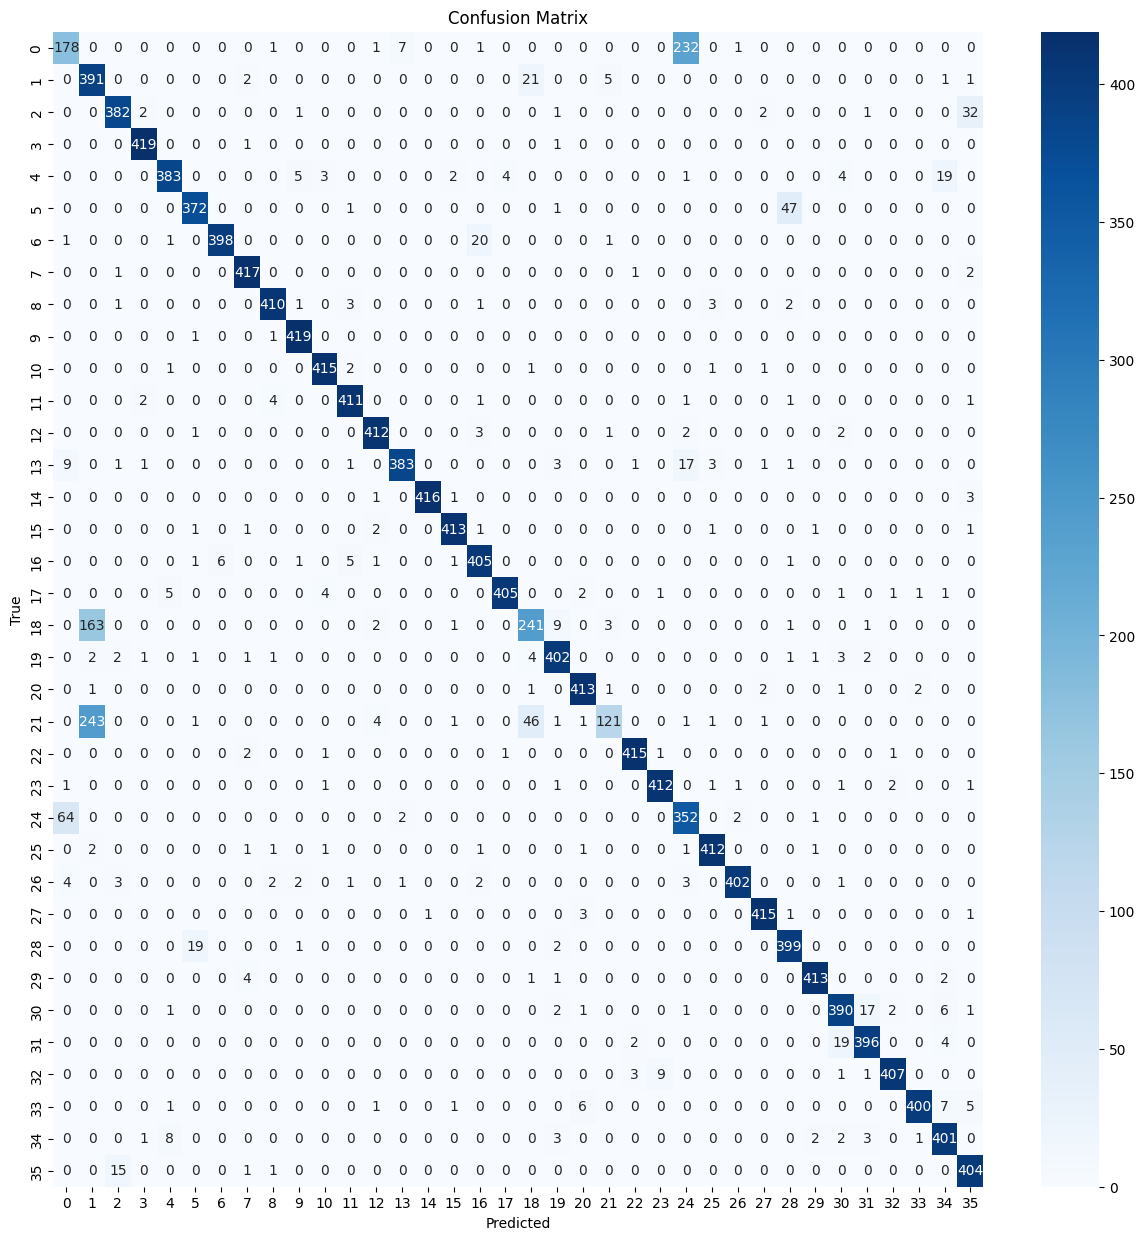

In [16]:
# Visualizing Confusion Matrix

cm = confusion_matrix(true_values, pred_values)
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

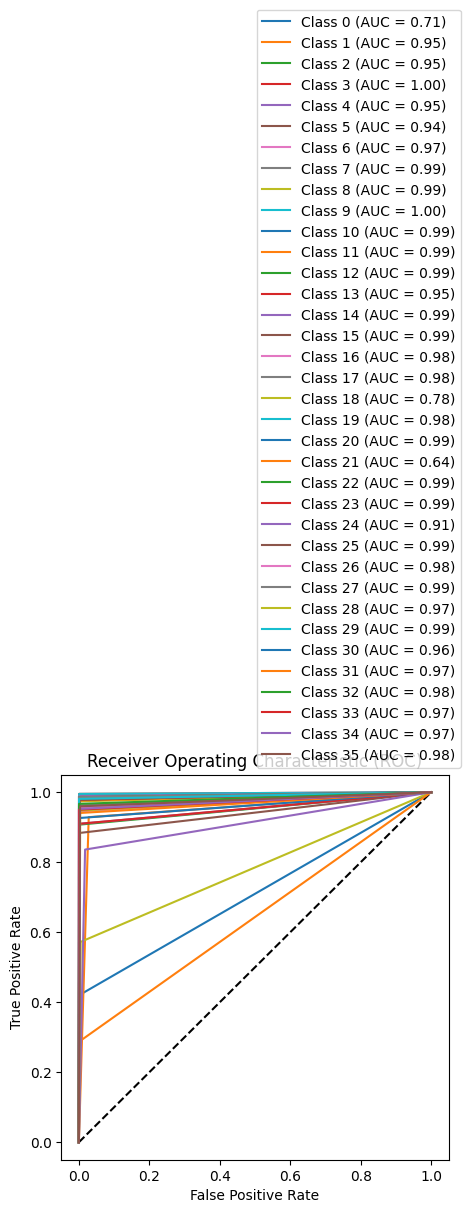

In [17]:
# ROC curve

fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert to one-hot encoded format
true_one_hot = np.eye(36)[true_values]
predicted_one_hot = np.eye(36)[pred_values]

for i in range(36):
    fpr[i], tpr[i], _ = roc_curve(true_one_hot[:, i], predicted_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(36):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 1))
plt.show()

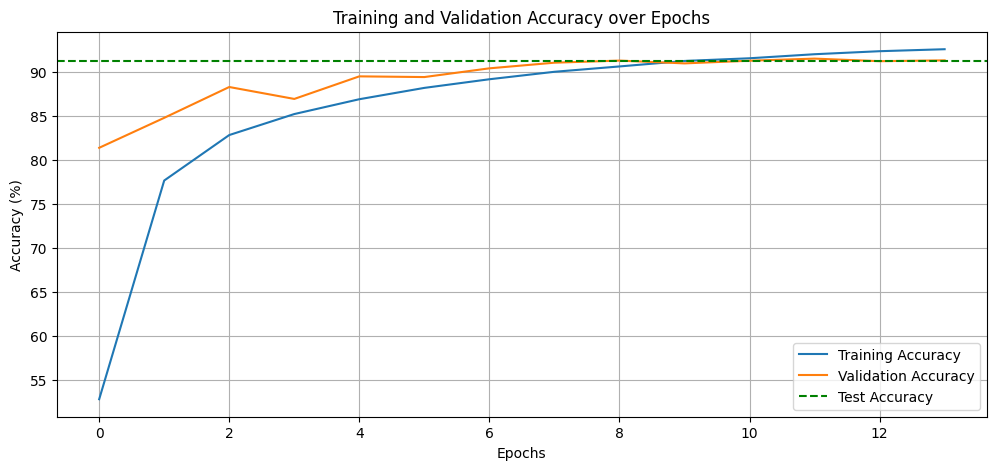

In [18]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.axhline(y=(accuracy.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

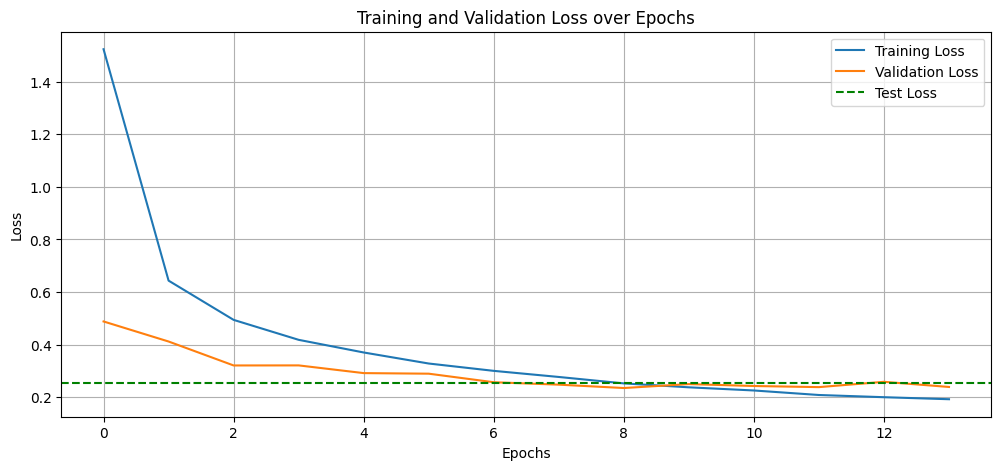

In [19]:
# Losses Plot
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.axhline(y=test_loss_per_batch, color='g', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Learning Rate Scheduler**

In [ ]:
# Instantiate the model

cnn_lrs = CNN().to(device)
print(cnn_lrs)

# Model summary
summary(cnn_lrs, input_size=(3, 28, 28))

CNN(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Selecting Cross Entropy Loss
criterion_lrs = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer_lrs = torch.optim.Adam(cnn_lrs.parameters(), lr=0.001)

In [ ]:
# Training and evaluating test and validation sets

train_accuracy_history_lrs, val_accuracy_history_lrs = [], []
train_loss_history_lrs, val_loss_history_lrs = [], []

# Scheduler
scheduler = ReduceLROnPlateau(optimizer_lrs, 'min', patience=10)

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss_lrs = float('inf')
no_improvement_count_lrs = 0

# Start train time
start_train_time_lrs = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    cnn_lrs.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer_lrs.zero_grad()
        outputs = cnn_lrs(images)
        loss = criterion_lrs(outputs, labels)
        loss.backward()
        optimizer_lrs.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    training_loss_per_batch_lrs = running_loss / len(train_loader)
    train_loss_history_lrs.append(training_loss_per_batch_lrs)
    train_accuracy_history_lrs.append(100. * correct_train / total_train)

    cnn_lrs.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_lrs(images)
            val_loss += criterion_lrs(outputs, labels).item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    validation_loss_per_batch_lrs = val_loss / len(val_loader)
    val_loss_history_lrs.append(validation_loss_per_batch_lrs)
    val_accuracy_history_lrs.append(100. * correct_val / total_val)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch_lrs}, Validation Loss: {validation_loss_per_batch_lrs}")

    # update learning rate
    scheduler.step(validation_loss_per_batch_lrs)

    # Early stopping
    if validation_loss_per_batch_lrs < best_validation_loss_lrs:
        best_validation_loss_lrs = validation_loss_per_batch_lrs
        no_improvement_count_lrs = 0
    else:
        no_improvement_count_lrs += 1
        if no_improvement_count_lrs >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time_lrs = time.time()
total_training_time_lrs = end_train_time_lrs - start_train_time_lrs

Loss for Epoch- 1: 
 Training Loss: 1.4096613242383877, Validation Loss: 0.42403380042176786
Loss for Epoch- 2: 
 Training Loss: 0.5754066178348666, Validation Loss: 0.35147960507897896
Loss for Epoch- 3: 
 Training Loss: 0.44307811896294735, Validation Loss: 0.2911112572246489
Loss for Epoch- 4: 
 Training Loss: 0.37027225615000336, Validation Loss: 0.2835442546457678
Loss for Epoch- 5: 
 Training Loss: 0.3264747501609546, Validation Loss: 0.25291136141666876
Loss for Epoch- 6: 
 Training Loss: 0.3010267814901909, Validation Loss: 0.2424368574831854
Loss for Epoch- 7: 
 Training Loss: 0.2786065609669296, Validation Loss: 0.25055798632092774
Loss for Epoch- 8: 
 Training Loss: 0.2623834146724206, Validation Loss: 0.2362713622391036
Loss for Epoch- 9: 
 Training Loss: 0.24699402635683815, Validation Loss: 0.24553558529362457
Loss for Epoch- 10: 
 Training Loss: 0.23878993299500695, Validation Loss: 0.24828603742739572
Loss for Epoch- 11: 
 Training Loss: 0.2216296093217258, Validation L

In [ ]:
# Printing the model weights

print(f"Model state: {cnn_lrs.state_dict()}")

Model state: OrderedDict([('conv1.weight', tensor([[[[-0.2215, -0.0031, -0.0208],
          [-0.0120,  0.1991,  0.1136],
          [ 0.0367, -0.1310, -0.1382]],

         [[-0.2345,  0.0046, -0.0749],
          [-0.0431,  0.1739,  0.0532],
          [ 0.1464,  0.1678, -0.2856]],

         [[-0.0549,  0.1455,  0.0621],
          [-0.0716,  0.2545,  0.0545],
          [-0.2109,  0.1079, -0.0520]]],


        [[[-0.1484,  0.0582,  0.0815],
          [ 0.1568, -0.0545,  0.1602],
          [ 0.1377, -0.2648,  0.0801]],

         [[ 0.0345,  0.1641, -0.1203],
          [-0.2007, -0.2221,  0.2506],
          [-0.0516,  0.1102,  0.1803]],

         [[ 0.0645, -0.0609,  0.1677],
          [-0.2133, -0.1532,  0.2618],
          [-0.1804, -0.2047, -0.1092]]],


        [[[ 0.0239,  0.1270, -0.0371],
          [ 0.0460,  0.2091,  0.0583],
          [ 0.2044,  0.2717,  0.1189]],

         [[-0.1380,  0.2005,  0.2368],
          [-0.0529,  0.0792,  0.2624],
          [-0.0187,  0.0797,  0.1423]],

 

In [ ]:
# Evaluating test dataset
test_loss_lrs = 0.0
total_test_lrs = 0
pred_values_lrs = []
true_values_lrs = []
accuracy_lrs = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_lrs(images)
        test_loss_lrs += criterion_lrs(outputs, labels).item()
        _, predicted = outputs.max(1)
        total_test_lrs += labels.size(0)

        accuracy_lrs(predicted, labels)

        # append predictions and true values
        pred_values_lrs.extend(predicted.cpu().numpy())
        true_values_lrs.extend(labels.cpu().numpy())

test_loss_per_batch_lrs = test_loss_lrs / len(test_loader)

In [ ]:
# calculate the evaluation metrices
precision_lrs = precision_score(true_values_lrs, pred_values_lrs, average='macro')
recall_lrs = recall_score(true_values_lrs, pred_values_lrs, average='macro')
f1_lrs = f1_score(true_values_lrs, pred_values_lrs, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time_lrs:.4f} seconds")
print(f"Accuracy: {accuracy_lrs.compute():.4f}")
print(f"Precision: {precision_lrs:.4f}")
print(f"Recall: {recall_lrs:.4f}")
print(f"F1 Score: {f1_lrs:.4f}")

Time to train: 711.0026 seconds
Accuracy: 0.9098
Precision: 0.9176
Recall: 0.9098
F1 Score: 0.9051


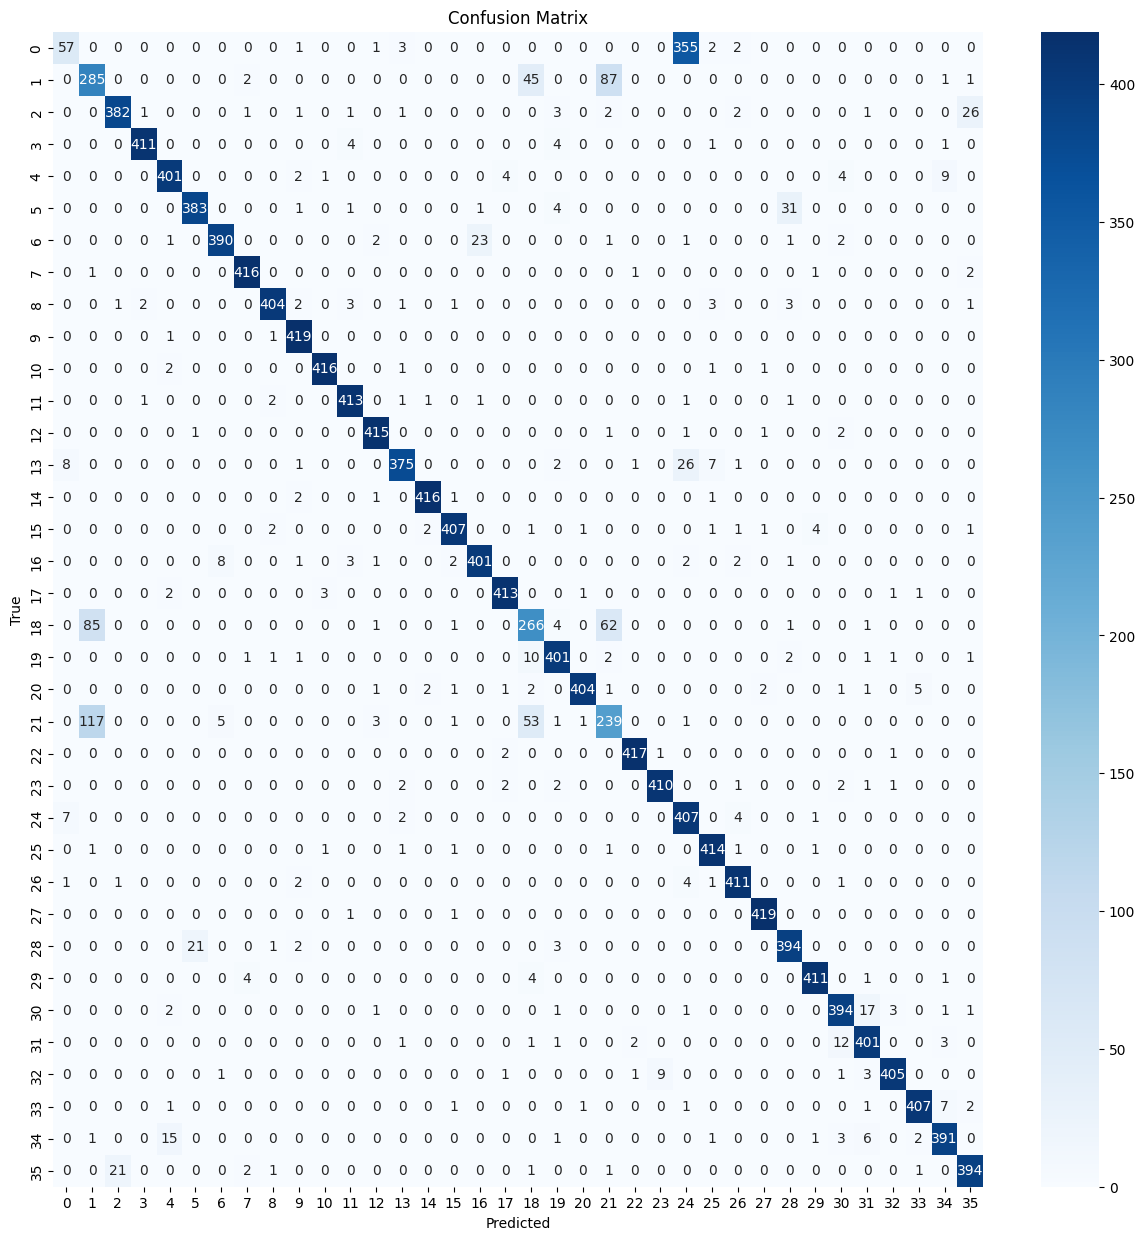

In [ ]:
# Visualizing Confusion Matrix

cm_lrs = confusion_matrix(true_values_lrs, pred_values_lrs)
plt.figure(figsize=(15,15))
sns.heatmap(cm_lrs, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

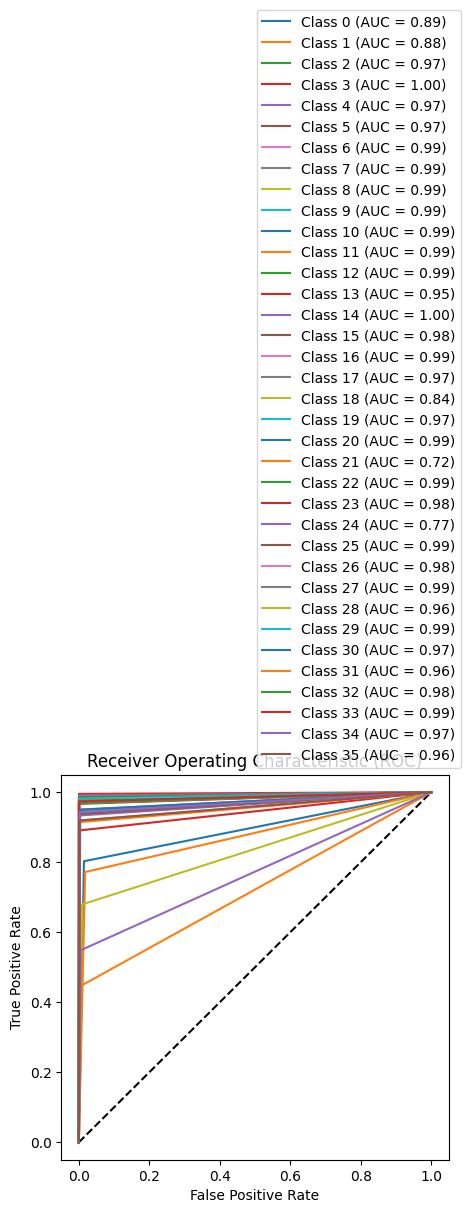

In [ ]:
# ROC curve

fpr_lrs = dict()
tpr_lrs = dict()
roc_auc_lrs = dict()

# Convert to one-hot encoded format
true_one_hot_lrs = np.eye(36)[true_values_lrs]
predicted_one_hot_lrs = np.eye(36)[pred_values_lrs]

for i in range(36):
    fpr_lrs[i], tpr_lrs[i], _ = roc_curve(true_one_hot_lrs[:, i], predicted_one_hot_lrs[:, i])
    roc_auc_lrs[i] = auc(fpr_lrs[i], tpr_lrs[i])


plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(36):
    plt.plot(fpr_lrs[i], tpr_lrs[i], label=f'Class {i} (AUC = {roc_auc_lrs[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 1))
plt.show()

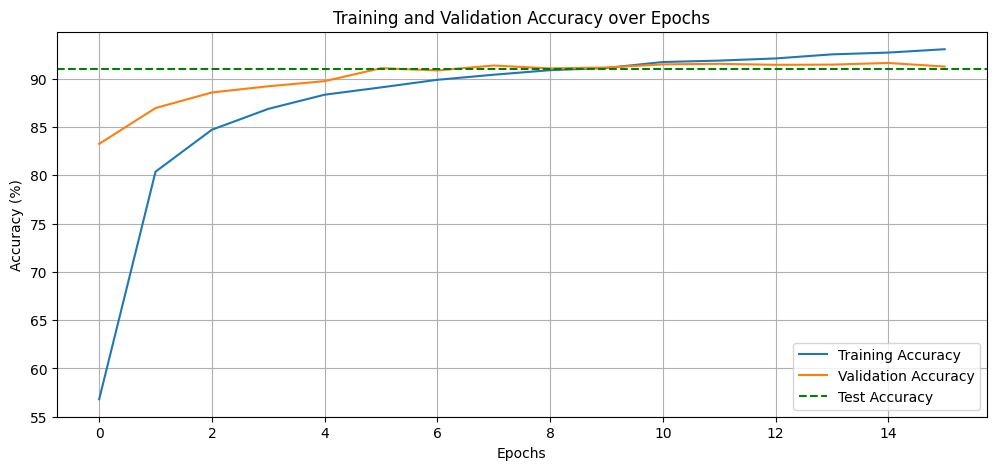

In [ ]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history_lrs, label='Training Accuracy')
plt.plot(val_accuracy_history_lrs, label='Validation Accuracy')
plt.axhline(y=(accuracy_lrs.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

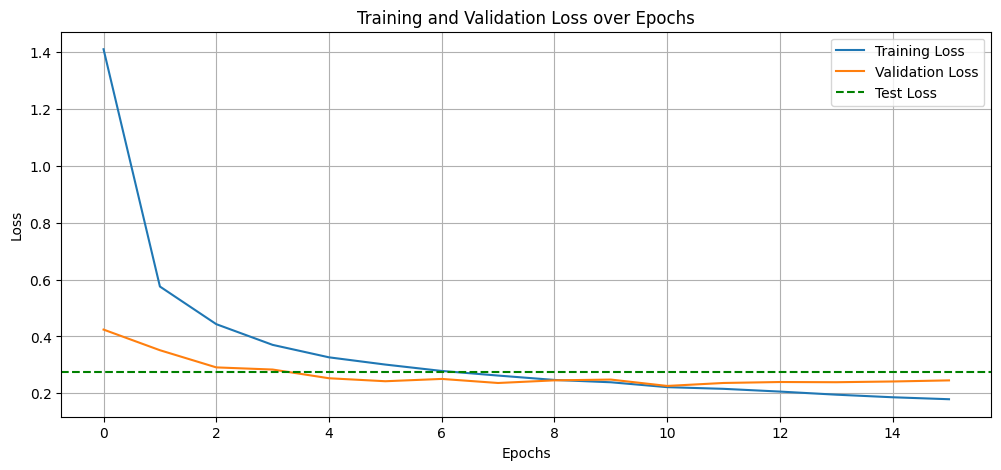

In [ ]:
# Losses Plot
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history_lrs, label='Training Loss')
plt.plot(val_loss_history_lrs, label='Validation Loss')
plt.axhline(y=test_loss_per_batch_lrs, color='g', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

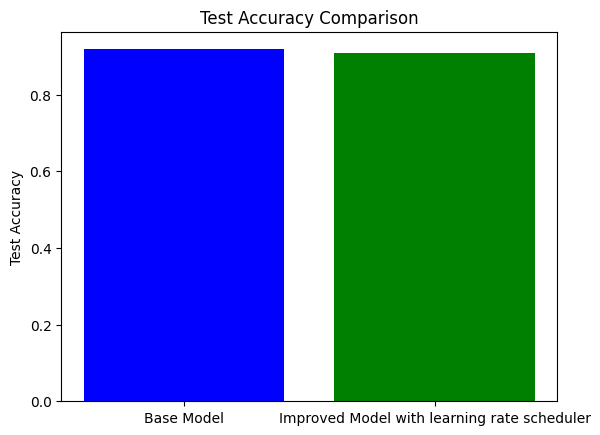

In [ ]:
# Data to plot
labels = ['Base Model', 'Improved Model with learning rate scheduler']
accuracies = [accuracy.compute(), accuracy_lrs.compute()]

# Bar chart
plt.bar(labels, accuracies, color=['blue', 'green'])
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.show()

**Gradient Accumulation**

In [20]:
# Instantiate the model

cnn_ga = CNN().to(device)
print(cnn_ga)

# Model summary
summary(cnn_ga, input_size=(3, 28, 28))

CNN(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5)

In [21]:
# Selecting Cross Entropy Loss
criterion_ga = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer_ga = torch.optim.Adam(cnn_ga.parameters(), lr=0.001)

In [22]:
# Training and evaluating test and validation sets

train_accuracy_history_ga, val_accuracy_history_ga = [], []
train_loss_history_ga, val_loss_history_ga = [], []

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss_ga = float('inf')
no_improvement_count_ga = 0

# Gradient accumulation step count
accumulation_steps = 2
gradient_history = []

# Start train time
start_train_time_ga = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    cnn_ga.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer_ga.zero_grad()
        outputs = cnn_ga(images)
        loss = criterion_ga(outputs, labels)
        loss.backward()

        # Collect Gradients
        gradient_history.append(loss.item())

        if (i + 1) % accumulation_steps == 0:
          optimizer_ga.step()
          running_loss += sum(gradient_history)
          gradient_history = []

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    training_loss_per_batch_ga = running_loss / len(train_loader)
    train_loss_history_ga.append(training_loss_per_batch_ga)
    train_accuracy_history_ga.append(100. * correct_train / total_train)

    cnn_ga.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_ga(images)
            val_loss += criterion_ga(outputs, labels).item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    validation_loss_per_batch_ga = val_loss / len(val_loader)
    val_loss_history_ga.append(validation_loss_per_batch_ga)
    val_accuracy_history_ga.append(100. * correct_val / total_val)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch_ga}, Validation Loss: {validation_loss_per_batch_ga}")

    # Early stopping
    if validation_loss_per_batch_ga < best_validation_loss_ga:
        best_validation_loss_ga = validation_loss_per_batch_ga
        no_improvement_count_ga = 0
    else:
        no_improvement_count_ga += 1
        if no_improvement_count_ga >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time_ga = time.time()
total_training_time_ga = end_train_time_ga - start_train_time_ga

Loss for Epoch- 1: 
 Training Loss: 2.120230166427453, Validation Loss: 0.6264913569854087
Loss for Epoch- 2: 
 Training Loss: 0.8627657484121202, Validation Loss: 0.415183376223475
Loss for Epoch- 3: 
 Training Loss: 0.6677579866238817, Validation Loss: 0.4019749778236787
Loss for Epoch- 4: 
 Training Loss: 0.5723656049765606, Validation Loss: 0.35162368701661334
Loss for Epoch- 5: 
 Training Loss: 0.501373334204653, Validation Loss: 0.361817745710997
Loss for Epoch- 6: 
 Training Loss: 0.4599722961061879, Validation Loss: 0.3089207493927048
Loss for Epoch- 7: 
 Training Loss: 0.4303478146691937, Validation Loss: 0.3084304216278701
Loss for Epoch- 8: 
 Training Loss: 0.39135782563967625, Validation Loss: 0.29664195188078557
Loss for Epoch- 9: 
 Training Loss: 0.3745092729853632, Validation Loss: 0.29450557456046594
Loss for Epoch- 10: 
 Training Loss: 0.3481667855798441, Validation Loss: 0.2761644021022924
Loss for Epoch- 11: 
 Training Loss: 0.3311060676503311, Validation Loss: 0.251

In [23]:
# Printing the model weights

print(f"Model state: {cnn_ga.state_dict()}")

Model state: OrderedDict([('conv1.weight', tensor([[[[-0.0646,  0.0374, -0.1616],
          [-0.2155,  0.2347,  0.0483],
          [-0.1840,  0.2108, -0.0482]],

         [[ 0.1417, -0.1622,  0.1121],
          [-0.0706,  0.0716,  0.0892],
          [ 0.0415,  0.1358,  0.1157]],

         [[ 0.0379,  0.1530, -0.1132],
          [-0.0810,  0.1522, -0.1585],
          [-0.1753,  0.0823, -0.0955]]],


        [[[-0.0165,  0.1342,  0.1364],
          [ 0.0186, -0.1142,  0.1136],
          [-0.2152,  0.0925, -0.0954]],

         [[-0.0475,  0.1091,  0.0759],
          [ 0.1283,  0.1846, -0.0338],
          [-0.0355,  0.2333,  0.0416]],

         [[-0.0760,  0.1897,  0.0772],
          [-0.2290,  0.1246,  0.1998],
          [-0.2445,  0.0888,  0.0480]]],


        [[[ 0.1679, -0.0354,  0.1465],
          [ 0.1548, -0.2000,  0.0305],
          [ 0.0366,  0.1425, -0.1925]],

         [[-0.1896, -0.2030,  0.2368],
          [-0.0345,  0.1750,  0.1307],
          [ 0.0666, -0.0825,  0.0954]],

 

In [24]:
# Evaluating test dataset
test_loss_ga = 0.0
total_test_ga = 0
pred_values_ga = []
true_values_ga = []
accuracy_ga = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_ga(images)
        test_loss_ga += criterion_ga(outputs, labels).item()
        _, predicted = outputs.max(1)
        total_test_ga += labels.size(0)

        accuracy_ga(predicted, labels)

        # append predictions and true values
        pred_values_ga.extend(predicted.cpu().numpy())
        true_values_ga.extend(labels.cpu().numpy())

test_loss_per_batch_ga = test_loss_ga / len(test_loader)

In [25]:
# calculate the evaluation metrices
precision_ga = precision_score(true_values_ga, pred_values_ga, average='macro')
recall_ga = recall_score(true_values_ga, pred_values_ga, average='macro')
f1_ga = f1_score(true_values_ga, pred_values_ga, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time_ga:.4f} seconds")
print(f"Accuracy: {accuracy_ga.compute():.4f}")
print(f"Precision: {precision_ga:.4f}")
print(f"Recall: {recall_ga:.4f}")
print(f"F1 Score: {f1_ga:.4f}")

Time to train: 990.5972 seconds
Accuracy: 0.9153
Precision: 0.9190
Recall: 0.9153
F1 Score: 0.9149


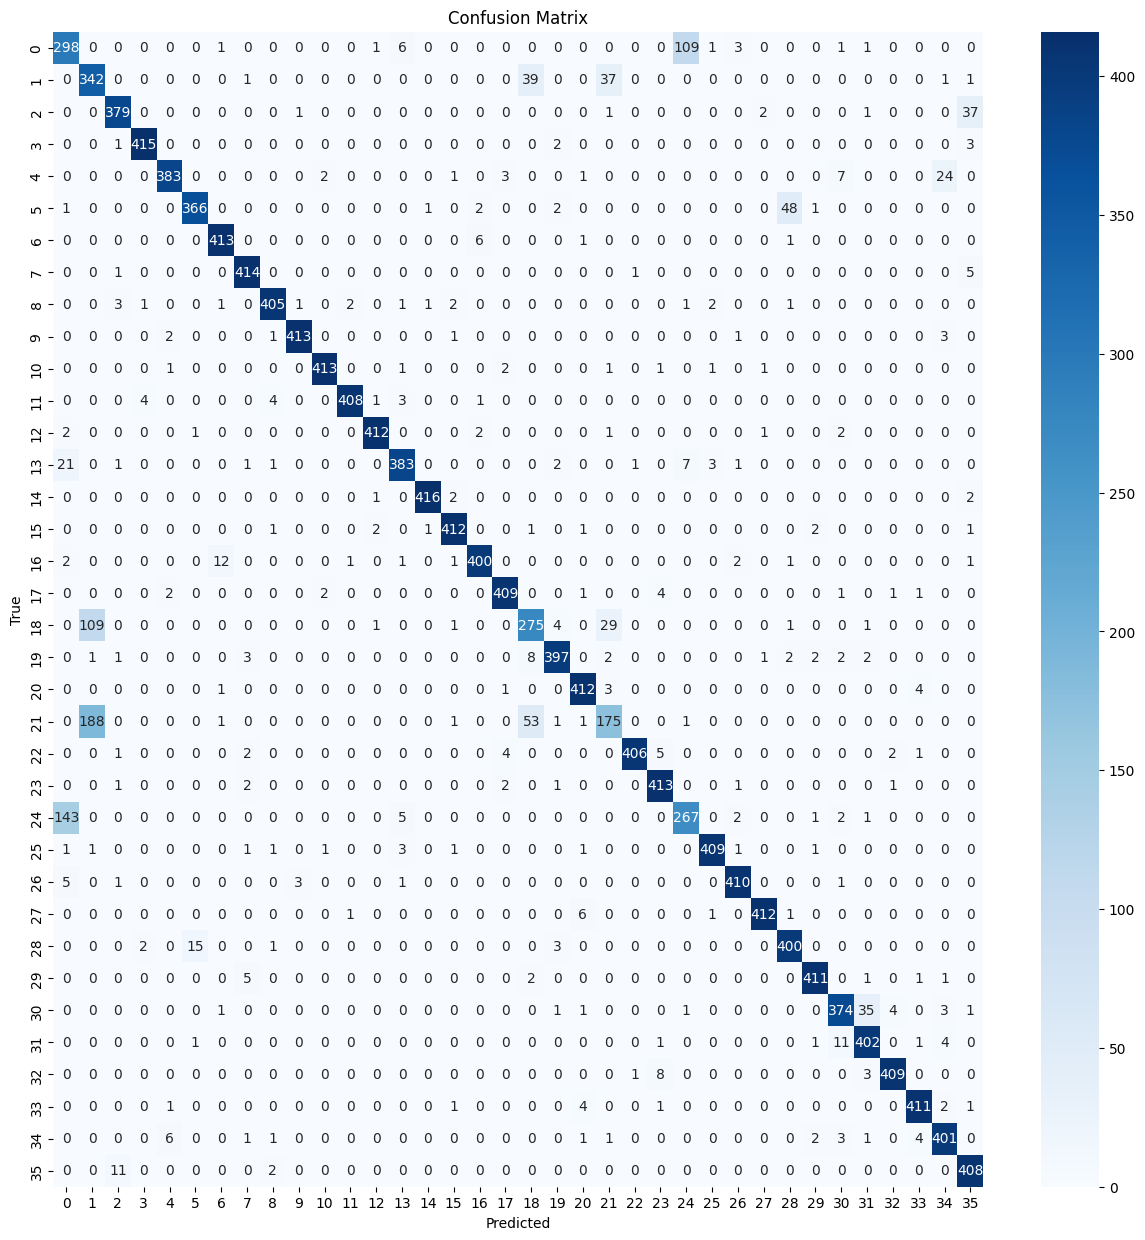

In [26]:
# Visualizing Confusion Matrix

cm_ga = confusion_matrix(true_values_ga, pred_values_ga)
plt.figure(figsize=(15,15))
sns.heatmap(cm_ga, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

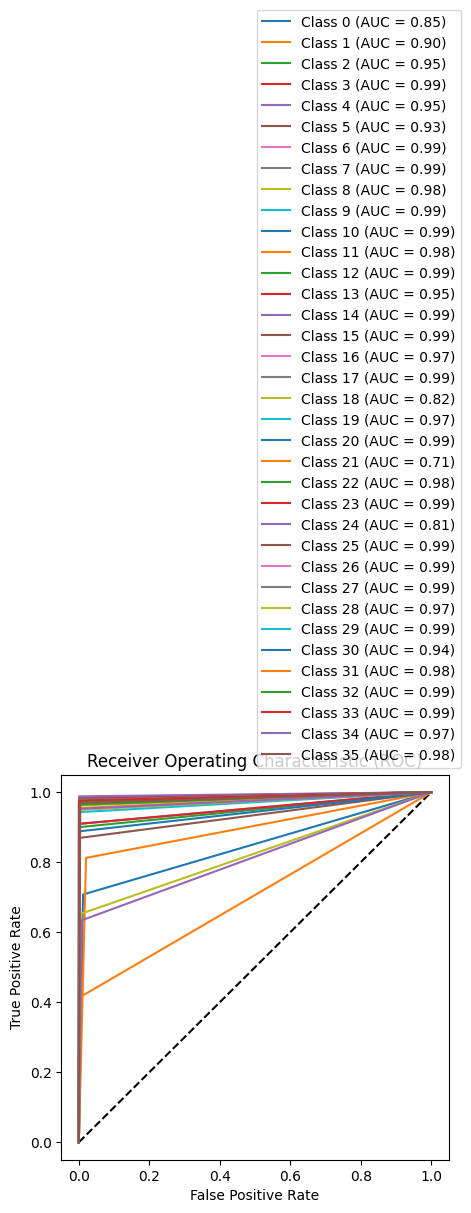

In [31]:
# ROC curve

fpr_ga = dict()
tpr_ga = dict()
roc_auc_ga = dict()

# Convert to one-hot encoded format
true_one_hot_ga = np.eye(36)[true_values_ga]
predicted_one_hot_ga = np.eye(36)[pred_values_ga]

for i in range(36):
    fpr_ga[i], tpr_ga[i], _ = roc_curve(true_one_hot_ga[:, i], predicted_one_hot_ga[:, i])
    roc_auc_ga[i] = auc(fpr_ga[i], tpr_ga[i])


plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(36):
    plt.plot(fpr_ga[i], tpr_ga[i], label=f'Class {i} (AUC = {roc_auc_ga[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 1))
plt.show()

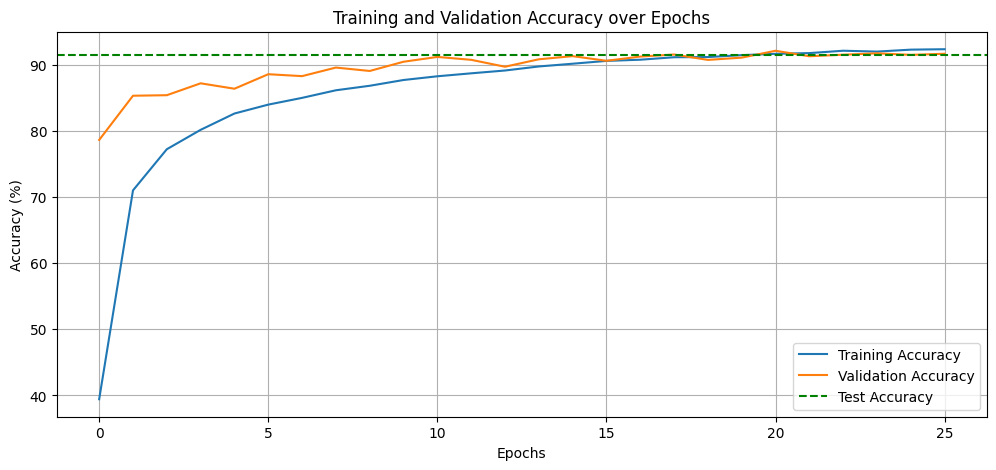

In [28]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history_ga, label='Training Accuracy')
plt.plot(val_accuracy_history_ga, label='Validation Accuracy')
plt.axhline(y=(accuracy_ga.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

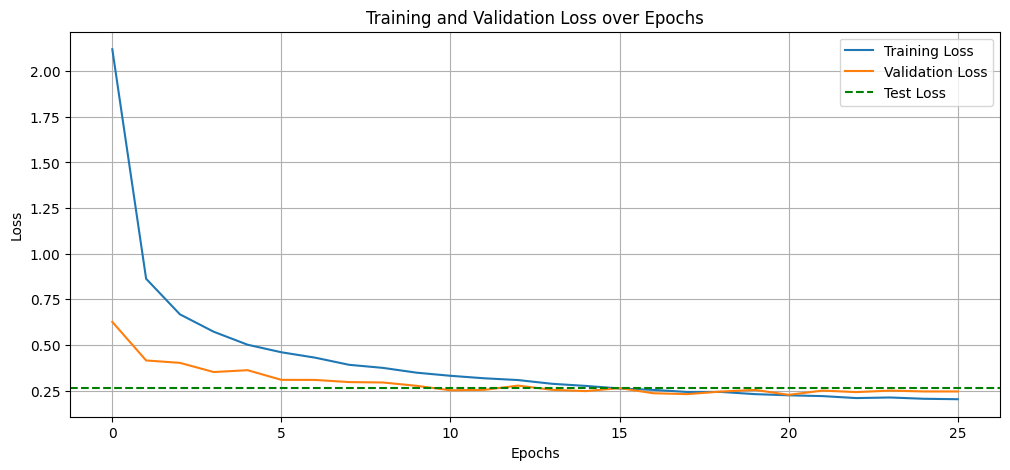

In [29]:
# Losses Plot
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history_ga, label='Training Loss')
plt.plot(val_loss_history_ga, label='Validation Loss')
plt.axhline(y=test_loss_per_batch_ga, color='g', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

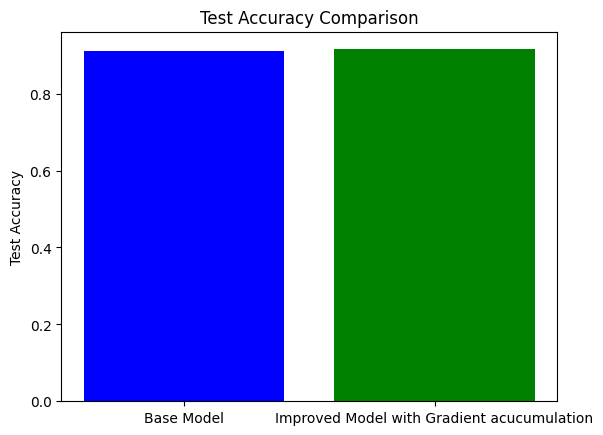

In [30]:
# Data to plot
labels = ['Base Model', 'Improved Model with Gradient acucumulation']
accuracies = [accuracy.compute(), accuracy_ga.compute()]

# Bar chart
plt.bar(labels, accuracies, color=['blue', 'green'])
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.show()

**Setup-1 Updating Dropout**

**sub-1(dp=0.6)**

In [ ]:
# Initialize the model
cnn_dp1 = CNN(dp = 0.6).to(device)
print(cnn_dp1)

# Model summary
summary(cnn_dp1, input_size=(3, 28, 28))

CNN(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5)

In [ ]:
# Selecting Cross Entropy Loss
criterion_dp1 = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer_dp1 = torch.optim.Adam(cnn_dp1.parameters(), lr=0.001)

In [ ]:
# Training and evaluating test and validation sets

train_accuracy_history_dp1, val_accuracy_history_dp1 = [], []
train_loss_history_dp1, val_loss_history_dp1 = [], []

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss_dp1 = float('inf')
no_improvement_count_dp1 = 0

# Start train time
start_train_time_dp1 = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    cnn_dp1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer_dp1.zero_grad()
        outputs = cnn_dp1(images)
        loss = criterion_dp1(outputs, labels)
        loss.backward()
        optimizer_dp1.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    training_loss_per_batch_dp1 = running_loss / len(train_loader)
    train_loss_history_dp1.append(training_loss_per_batch_dp1)
    train_accuracy_history_dp1.append(100. * correct_train / total_train)

    cnn_dp1.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_dp1(images)
            val_loss += criterion_dp1(outputs, labels).item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    validation_loss_per_batch_dp1 = val_loss / len(val_loader)
    val_loss_history_dp1.append(validation_loss_per_batch_dp1)
    val_accuracy_history_dp1.append(100. * correct_val / total_val)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch_dp1}, Validation Loss: {validation_loss_per_batch_dp1}")

    # Early stopping
    if validation_loss_per_batch_dp1 < best_validation_loss_dp1:
        best_validation_loss_dp1 = validation_loss_per_batch_dp1
        no_improvement_count_dp1 = 0
    else:
        no_improvement_count_dp1 += 1
        if no_improvement_count_dp1 >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time_dp1 = time.time()
total_training_time_dp1 = end_train_time_dp1 - start_train_time_dp1

Loss for Epoch- 1: 
 Training Loss: 1.9208391759875898, Validation Loss: 0.7118345643354564
Loss for Epoch- 2: 
 Training Loss: 0.9262912873780446, Validation Loss: 0.41491195087188054
Loss for Epoch- 3: 
 Training Loss: 0.6603122973939685, Validation Loss: 0.3717629977955851
Loss for Epoch- 4: 
 Training Loss: 0.4937232752244399, Validation Loss: 0.3082251997680223
Loss for Epoch- 5: 
 Training Loss: 0.3762991645807796, Validation Loss: 0.2546439230130954
Loss for Epoch- 6: 
 Training Loss: 0.3151180270092457, Validation Loss: 0.2688519266921197
Loss for Epoch- 7: 
 Training Loss: 0.27844361675575297, Validation Loss: 0.2728040700730919
Loss for Epoch- 8: 
 Training Loss: 0.2563927714761935, Validation Loss: 0.2894786692111574
Loss for Epoch- 9: 
 Training Loss: 0.24095118256748912, Validation Loss: 0.2496172684019685
Loss for Epoch- 10: 
 Training Loss: 0.22614315744428581, Validation Loss: 0.22670212606537476
Loss for Epoch- 11: 
 Training Loss: 0.2140966233021551, Validation Loss: 

In [ ]:
# Printing the model weights

print(f"Model state: {cnn_dp1.state_dict()}")

Model state: OrderedDict([('conv1.weight', tensor([[[[-0.1241, -0.2215, -0.1458],
          [ 0.1628,  0.1535, -0.0581],
          [ 0.1929, -0.0553,  0.0391]],

         [[-0.1160, -0.2210, -0.2203],
          [-0.0895, -0.0388, -0.1336],
          [ 0.2222, -0.0970,  0.0817]],

         [[-0.1830,  0.0305, -0.1369],
          [ 0.0298,  0.1379, -0.1985],
          [ 0.0724,  0.1436,  0.0516]]],


        [[[ 0.2597,  0.0758,  0.1355],
          [-0.1842, -0.0541,  0.1240],
          [-0.0572, -0.0807, -0.0040]],

         [[ 0.0999, -0.0332, -0.1415],
          [ 0.0226, -0.0138,  0.0526],
          [-0.2888, -0.1662, -0.1235]],

         [[-0.0487, -0.1395, -0.1124],
          [ 0.0471, -0.1312, -0.1561],
          [-0.3067, -0.1930,  0.0580]]],


        [[[-0.0019, -0.0520,  0.0246],
          [-0.0732, -0.0664,  0.2299],
          [-0.2315, -0.0236, -0.1820]],

         [[-0.1515,  0.0097,  0.1389],
          [-0.0258, -0.0862,  0.2156],
          [-0.0151, -0.1958,  0.0778]],

 

In [ ]:
# Evaluating test dataset
test_loss_dp1 = 0.0
total_test_dp1 = 0
pred_values_dp1 = []
true_values_dp1 = []
accuracy_dp1 = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_dp1(images)
        test_loss_dp1 += criterion_dp1(outputs, labels).item()
        _, predicted = outputs.max(1)
        total_test_dp1 += labels.size(0)

        accuracy_dp1(predicted, labels)

        # append predictions and true values
        pred_values_dp1.extend(predicted.cpu().numpy())
        true_values_dp1.extend(labels.cpu().numpy())

test_loss_per_batch_dp1 = test_loss_dp1 / len(test_loader)

In [ ]:
# calculate the evaluation metrices
precision_dp1 = precision_score(true_values_dp1, pred_values_dp1, average='macro')
recall_dp1 = recall_score(true_values_dp1, pred_values_dp1, average='macro')
f1_dp1 = f1_score(true_values_dp1, pred_values_dp1, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time_dp1:.4f} seconds")
print(f"Accuracy: {accuracy_dp1.compute():.4f}")
print(f"Precision: {precision_dp1:.4f}")
print(f"Recall: {recall_dp1:.4f}")
print(f"F1 Score: {f1_dp1:.4f}")

Time to train: 1501.6133 seconds
Accuracy: 0.9172
Precision: 0.9183
Recall: 0.9172
F1 Score: 0.9170


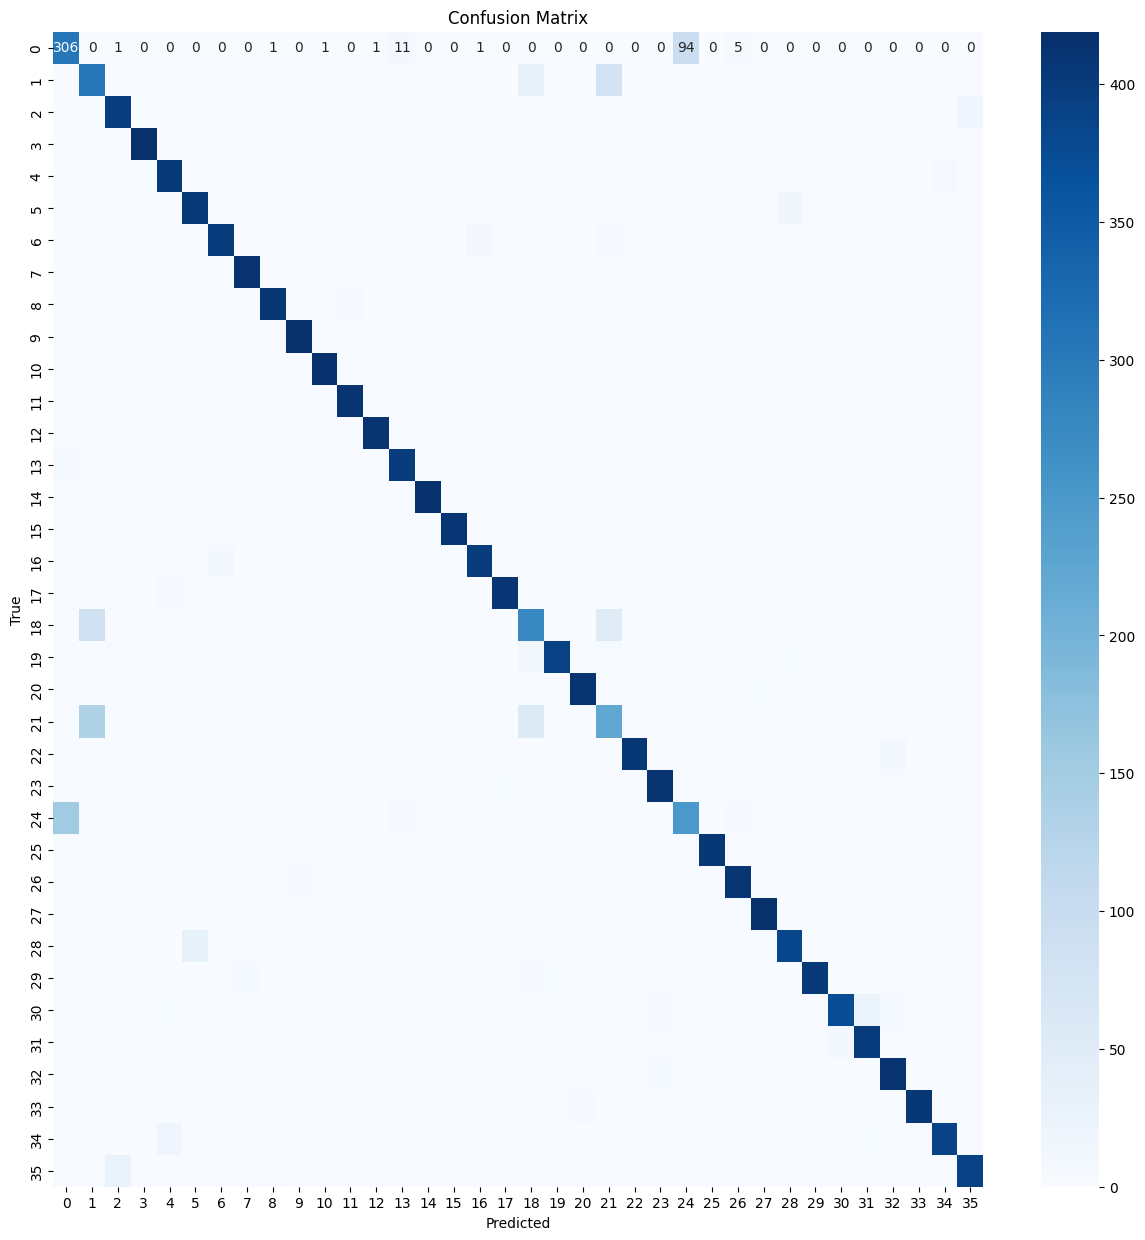

In [ ]:
# Visualizing Confusion Matrix

cm_dp1 = confusion_matrix(true_values_dp1, pred_values_dp1)
plt.figure(figsize=(15,15))
sns.heatmap(cm_dp1, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

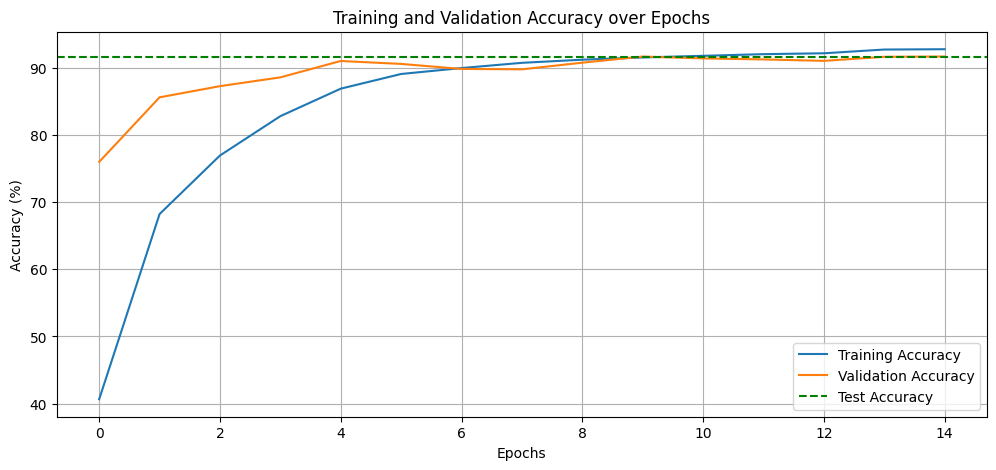

In [ ]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history_dp1, label='Training Accuracy')
plt.plot(val_accuracy_history_dp1, label='Validation Accuracy')
plt.axhline(y=(accuracy_dp1.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

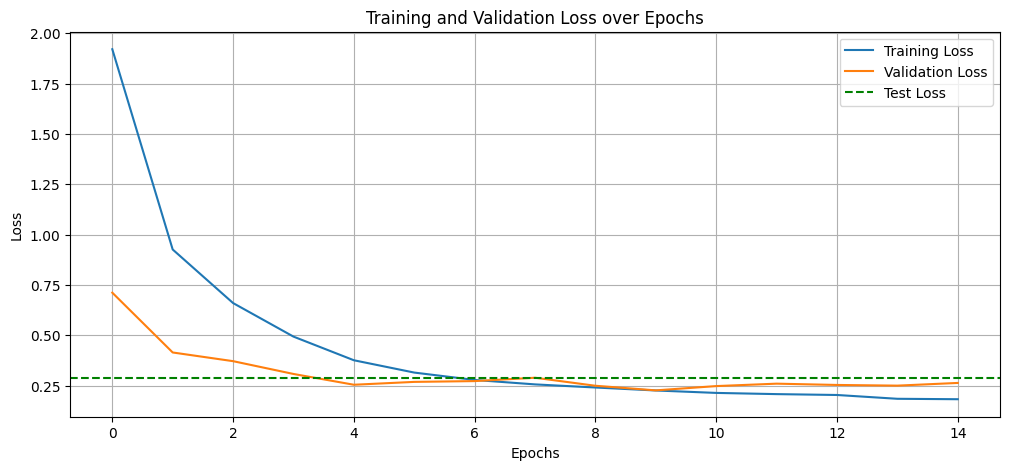

In [ ]:
# Losses Plot
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history_dp1, label='Training Loss')
plt.plot(val_loss_history_dp1, label='Validation Loss')
plt.axhline(y=test_loss_per_batch_dp1, color='g', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**sub-2(dp=0.7)**

In [ ]:
# Initialize the model
cnn_dp2 = CNN(dp = 0.7).to(device)
print(cnn_dp2)

# Model summary
summary(cnn_dp2, input_size=(3, 28, 28))

CNN(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5)

In [ ]:
# Selecting Cross Entropy Loss
criterion_dp2 = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer_dp2 = torch.optim.Adam(cnn_dp2.parameters(), lr=0.001)

In [ ]:
# Training and evaluating test and validation sets

train_accuracy_history_dp2, val_accuracy_history_dp2 = [], []
train_loss_history_dp2, val_loss_history_dp2 = [], []

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss_dp2 = float('inf')
no_improvement_count_dp2 = 0

# Start train time
start_train_time_dp2 = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    cnn_dp2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer_dp2.zero_grad()
        outputs = cnn_dp2(images)
        loss = criterion_dp2(outputs, labels)
        loss.backward()
        optimizer_dp2.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    training_loss_per_batch_dp2 = running_loss / len(train_loader)
    train_loss_history_dp2.append(training_loss_per_batch_dp2)
    train_accuracy_history_dp2.append(100. * correct_train / total_train)

    cnn_dp2.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_dp2(images)
            val_loss += criterion_dp2(outputs, labels).item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    validation_loss_per_batch_dp2 = val_loss / len(val_loader)
    val_loss_history_dp2.append(validation_loss_per_batch_dp2)
    val_accuracy_history_dp2.append(100. * correct_val / total_val)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch_dp2}, Validation Loss: {validation_loss_per_batch_dp2}")

    # Early stopping
    if validation_loss_per_batch_dp2 < best_validation_loss_dp2:
        best_validation_loss_dp2 = validation_loss_per_batch_dp2
        no_improvement_count_dp2 = 0
    else:
        no_improvement_count_dp2 += 1
        if no_improvement_count_dp2 >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time_dp2 = time.time()
total_training_time_dp2 = end_train_time_dp2 - start_train_time_dp2

Loss for Epoch- 1: 
 Training Loss: 2.2631072208366465, Validation Loss: 0.7908355102819555
Loss for Epoch- 2: 
 Training Loss: 1.2173371017520094, Validation Loss: 0.4795609204677724
Loss for Epoch- 3: 
 Training Loss: 0.6262291157635067, Validation Loss: 0.32314182065051644
Loss for Epoch- 4: 
 Training Loss: 0.39266323215732124, Validation Loss: 0.2635235952510804
Loss for Epoch- 5: 
 Training Loss: 0.3172915168174166, Validation Loss: 0.27329216692929287
Loss for Epoch- 6: 
 Training Loss: 0.28145026753634594, Validation Loss: 0.26436241898497864
Loss for Epoch- 7: 
 Training Loss: 0.2603606533549875, Validation Loss: 0.2666817946465169
Loss for Epoch- 8: 
 Training Loss: 0.24739151041001461, Validation Loss: 0.24713523026375772
Loss for Epoch- 9: 
 Training Loss: 0.23324196009529913, Validation Loss: 0.23949442965275913
Loss for Epoch- 10: 
 Training Loss: 0.22993854227764854, Validation Loss: 0.248998402625698
Loss for Epoch- 11: 
 Training Loss: 0.2117806969720958, Validation Lo

In [ ]:
# Printing the model weights

print(f"Model state: {cnn_dp2.state_dict()}")

Model state: OrderedDict([('conv1.weight', tensor([[[[-0.1087, -0.1851,  0.1625],
          [ 0.0483,  0.2009,  0.0898],
          [ 0.0906,  0.1087, -0.2435]],

         [[-0.0958, -0.2230,  0.2244],
          [-0.2073, -0.0109,  0.0545],
          [ 0.0695, -0.1553, -0.0351]],

         [[ 0.1123, -0.0731,  0.0918],
          [ 0.0311,  0.0568, -0.0465],
          [ 0.0627,  0.1612, -0.2120]]],


        [[[ 0.0653, -0.1383, -0.1912],
          [-0.1031, -0.0556, -0.1620],
          [ 0.1790, -0.1160, -0.0303]],

         [[-0.0312,  0.1171,  0.0690],
          [ 0.0789, -0.0293, -0.2943],
          [ 0.1611,  0.1576, -0.0960]],

         [[ 0.0595,  0.1760,  0.0658],
          [ 0.2450,  0.0445, -0.2558],
          [ 0.2290, -0.0232, -0.0407]]],


        [[[ 0.1233, -0.1698,  0.1677],
          [-0.2018, -0.1806,  0.0789],
          [ 0.0221, -0.1702,  0.0468]],

         [[-0.0390,  0.0881,  0.2180],
          [-0.2244, -0.2065, -0.0229],
          [ 0.1616, -0.1324, -0.1995]],

 

In [ ]:
# Evaluating test dataset
test_loss_dp2 = 0.0
total_test_dp2 = 0
pred_values_dp2 = []
true_values_dp2 = []
accuracy_dp2 = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_dp2(images)
        test_loss_dp2 += criterion_dp2(outputs, labels).item()
        _, predicted = outputs.max(1)
        total_test_dp2 += labels.size(0)

        accuracy_dp2(predicted, labels)

        # append predictions and true values
        pred_values_dp2.extend(predicted.cpu().numpy())
        true_values_dp2.extend(labels.cpu().numpy())

test_loss_per_batch_dp2 = test_loss_dp2 / len(test_loader)

In [ ]:
# calculate the evaluation metrices
precision_dp2 = precision_score(true_values_dp2, pred_values_dp2, average='macro')
recall_dp2 = recall_score(true_values_dp2, pred_values_dp2, average='macro')
f1_dp2 = f1_score(true_values_dp2, pred_values_dp2, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time_dp2:.4f} seconds")
print(f"Accuracy: {accuracy_dp2.compute():.4f}")
print(f"Precision: {precision_dp2:.4f}")
print(f"Recall: {recall_dp2:.4f}")
print(f"F1 Score: {f1_dp2:.4f}")

Time to train: 1627.7923 seconds
Accuracy: 0.9169
Precision: 0.9243
Recall: 0.9169
F1 Score: 0.9161


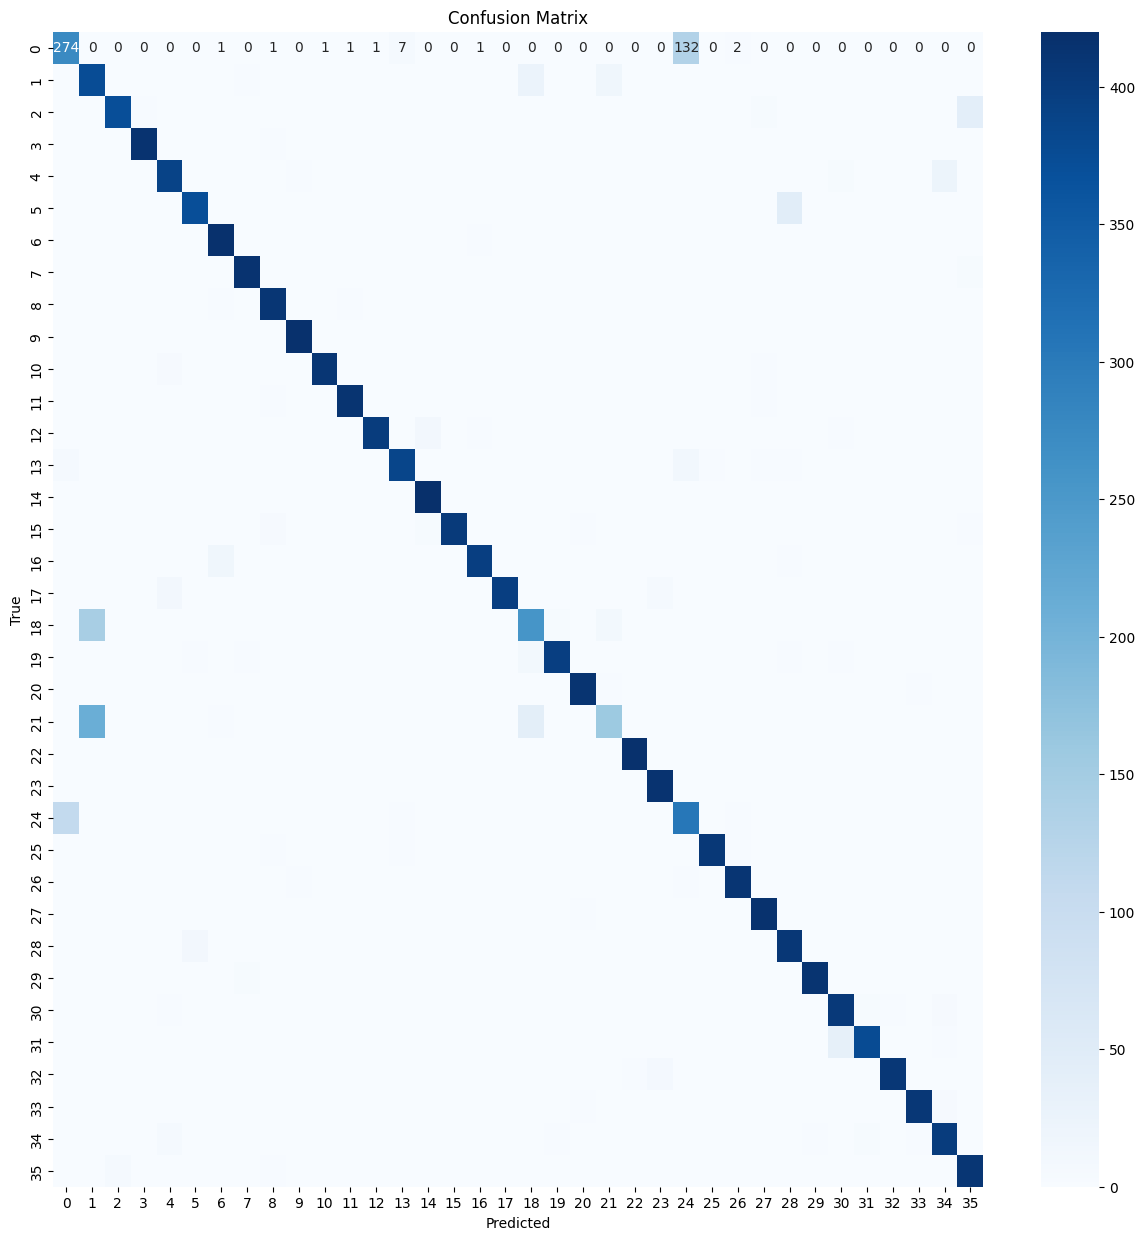

In [ ]:
# Visualizing Confusion Matrix

cm_dp2 = confusion_matrix(true_values_dp2, pred_values_dp2)
plt.figure(figsize=(15,15))
sns.heatmap(cm_dp2, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

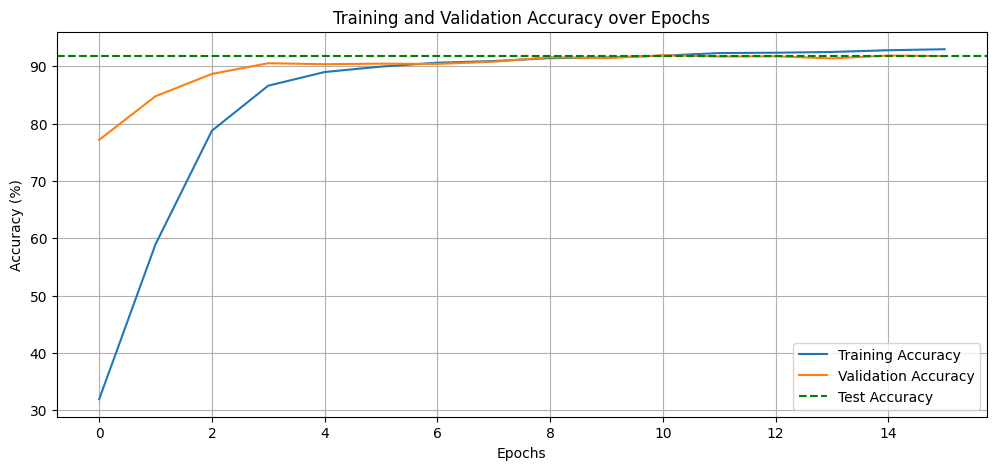

In [ ]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history_dp2, label='Training Accuracy')
plt.plot(val_accuracy_history_dp2, label='Validation Accuracy')
plt.axhline(y=(accuracy_dp2.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

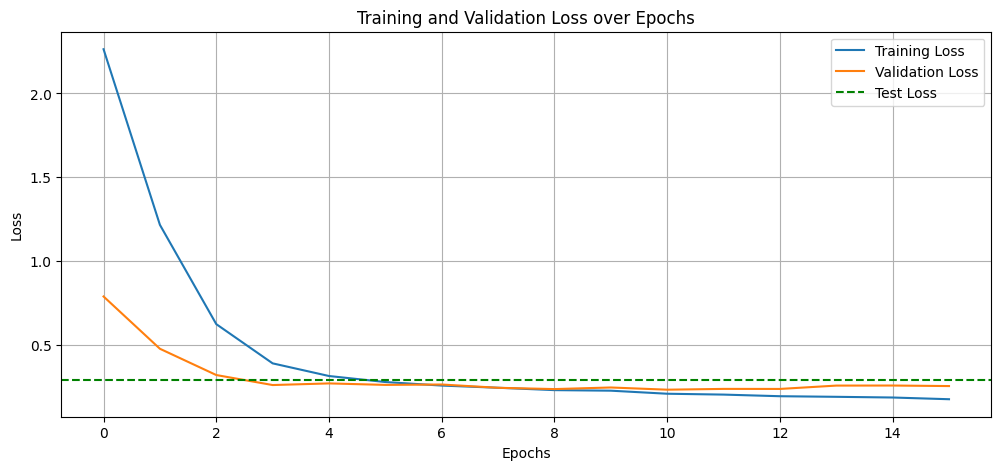

In [ ]:
# Losses Plot
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history_dp2, label='Training Loss')
plt.plot(val_loss_history_dp2, label='Validation Loss')
plt.axhline(y=test_loss_per_batch_dp2, color='g', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**sub-3(dp=0.4)**

In [ ]:
# Initialize the model
cnn_dp3 = CNN(dp = 0.4).to(device)
print(cnn_dp3)

# Model summary
summary(cnn_dp3, input_size=(3, 28, 28))

CNN(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5)

In [ ]:
# Selecting Cross Entropy Loss
criterion_dp3 = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer_dp3 = torch.optim.Adam(cnn_dp3.parameters(), lr=0.001)

In [ ]:
# Training and evaluating test and validation sets

train_accuracy_history_dp3, val_accuracy_history_dp3 = [], []
train_loss_history_dp3, val_loss_history_dp3 = [], []

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss_dp3 = float('inf')
no_improvement_count_dp3 = 0

# Start train time
start_train_time_dp3 = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    cnn_dp3.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer_dp3.zero_grad()
        outputs = cnn_dp3(images)
        loss = criterion_dp3(outputs, labels)
        loss.backward()
        optimizer_dp3.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    training_loss_per_batch_dp3 = running_loss / len(train_loader)
    train_loss_history_dp3.append(training_loss_per_batch_dp3)
    train_accuracy_history_dp3.append(100. * correct_train / total_train)

    cnn_dp3.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_dp3(images)
            val_loss += criterion_dp3(outputs, labels).item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    validation_loss_per_batch_dp3 = val_loss / len(val_loader)
    val_loss_history_dp3.append(validation_loss_per_batch_dp3)
    val_accuracy_history_dp3.append(100. * correct_val / total_val)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch_dp3}, Validation Loss: {validation_loss_per_batch_dp3}")

    # Early stopping
    if validation_loss_per_batch_dp3 < best_validation_loss_dp3:
        best_validation_loss_dp3 = validation_loss_per_batch_dp3
        no_improvement_count_dp3 = 0
    else:
        no_improvement_count_dp3 += 1
        if no_improvement_count_dp3 >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time_dp3 = time.time()
total_training_time_dp3 = end_train_time_dp3 - start_train_time_dp3

Loss for Epoch- 1: 
 Training Loss: 1.4129304051291056, Validation Loss: 0.42271618160004376
Loss for Epoch- 2: 
 Training Loss: 0.5167701446642244, Validation Loss: 0.3191672818130665
Loss for Epoch- 3: 
 Training Loss: 0.40985457518031504, Validation Loss: 0.29117697100115925
Loss for Epoch- 4: 
 Training Loss: 0.3594661957285149, Validation Loss: 0.267756295384802
Loss for Epoch- 5: 
 Training Loss: 0.3169515613338043, Validation Loss: 0.25436301881392653
Loss for Epoch- 6: 
 Training Loss: 0.2903826091228942, Validation Loss: 0.25540458619938927
Loss for Epoch- 7: 
 Training Loss: 0.2750007718828542, Validation Loss: 0.24957181399828998
Loss for Epoch- 8: 
 Training Loss: 0.2594742392157686, Validation Loss: 0.2365909498791453
Loss for Epoch- 9: 
 Training Loss: 0.24707836287261786, Validation Loss: 0.24350222947952502
Loss for Epoch- 10: 
 Training Loss: 0.23243917966981548, Validation Loss: 0.23800547474979603
Loss for Epoch- 11: 
 Training Loss: 0.22769514211671538, Validation L

In [ ]:
# Printing the model weights
print(f"Model state: {cnn_dp3.state_dict()}")

Model state: OrderedDict([('conv1.weight', tensor([[[[-0.0110, -0.0948,  0.0602],
          [ 0.0767, -0.0008, -0.1252],
          [ 0.0367,  0.1972, -0.0596]],

         [[-0.0409, -0.2478, -0.0617],
          [ 0.1715, -0.1671, -0.1078],
          [ 0.2471,  0.0513, -0.0046]],

         [[-0.1293, -0.2072, -0.1995],
          [-0.0024,  0.0952,  0.0774],
          [ 0.2936, -0.0767,  0.1267]]],


        [[[-0.1080,  0.1088,  0.0092],
          [ 0.1548, -0.2436, -0.1414],
          [ 0.0799, -0.2090,  0.1836]],

         [[ 0.1005,  0.0996,  0.0234],
          [ 0.1214, -0.1491,  0.1912],
          [ 0.0560, -0.2973,  0.2308]],

         [[ 0.0457, -0.0975, -0.1066],
          [ 0.0728, -0.0091, -0.1135],
          [ 0.0508, -0.1237, -0.0163]]],


        [[[-0.1534, -0.3278,  0.1350],
          [ 0.0366, -0.3036,  0.1108],
          [-0.0339, -0.1256, -0.1114]],

         [[-0.2716, -0.2554,  0.0192],
          [-0.1760, -0.1359, -0.1936],
          [ 0.1241, -0.1971, -0.0537]],

 

In [ ]:
# Evaluating test dataset
test_loss_dp3 = 0.0
total_test_dp3 = 0
pred_values_dp3 = []
true_values_dp3 = []
accuracy_dp3 = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_dp3(images)
        test_loss_dp3 += criterion_dp3(outputs, labels).item()
        _, predicted = outputs.max(1)
        total_test_dp3 += labels.size(0)

        accuracy_dp3(predicted, labels)

        # append predictions and true values
        pred_values_dp3.extend(predicted.cpu().numpy())
        true_values_dp3.extend(labels.cpu().numpy())

test_loss_per_batch_dp3 = test_loss_dp3 / len(test_loader)

In [ ]:
# calculate the evaluation metrices
precision_dp3 = precision_score(true_values_dp3, pred_values_dp3, average='macro')
recall_dp3 = recall_score(true_values_dp3, pred_values_dp3, average='macro')
f1_dp3 = f1_score(true_values_dp3, pred_values_dp3, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time_dp3:.4f} seconds")
print(f"Accuracy: {accuracy_dp3.compute():.4f}")
print(f"Precision: {precision_dp3:.4f}")
print(f"Recall: {recall_dp3:.4f}")
print(f"F1 Score: {f1_dp3:.4f}")

Time to train: 1879.4495 seconds
Accuracy: 0.9175
Precision: 0.9220
Recall: 0.9175
F1 Score: 0.9168


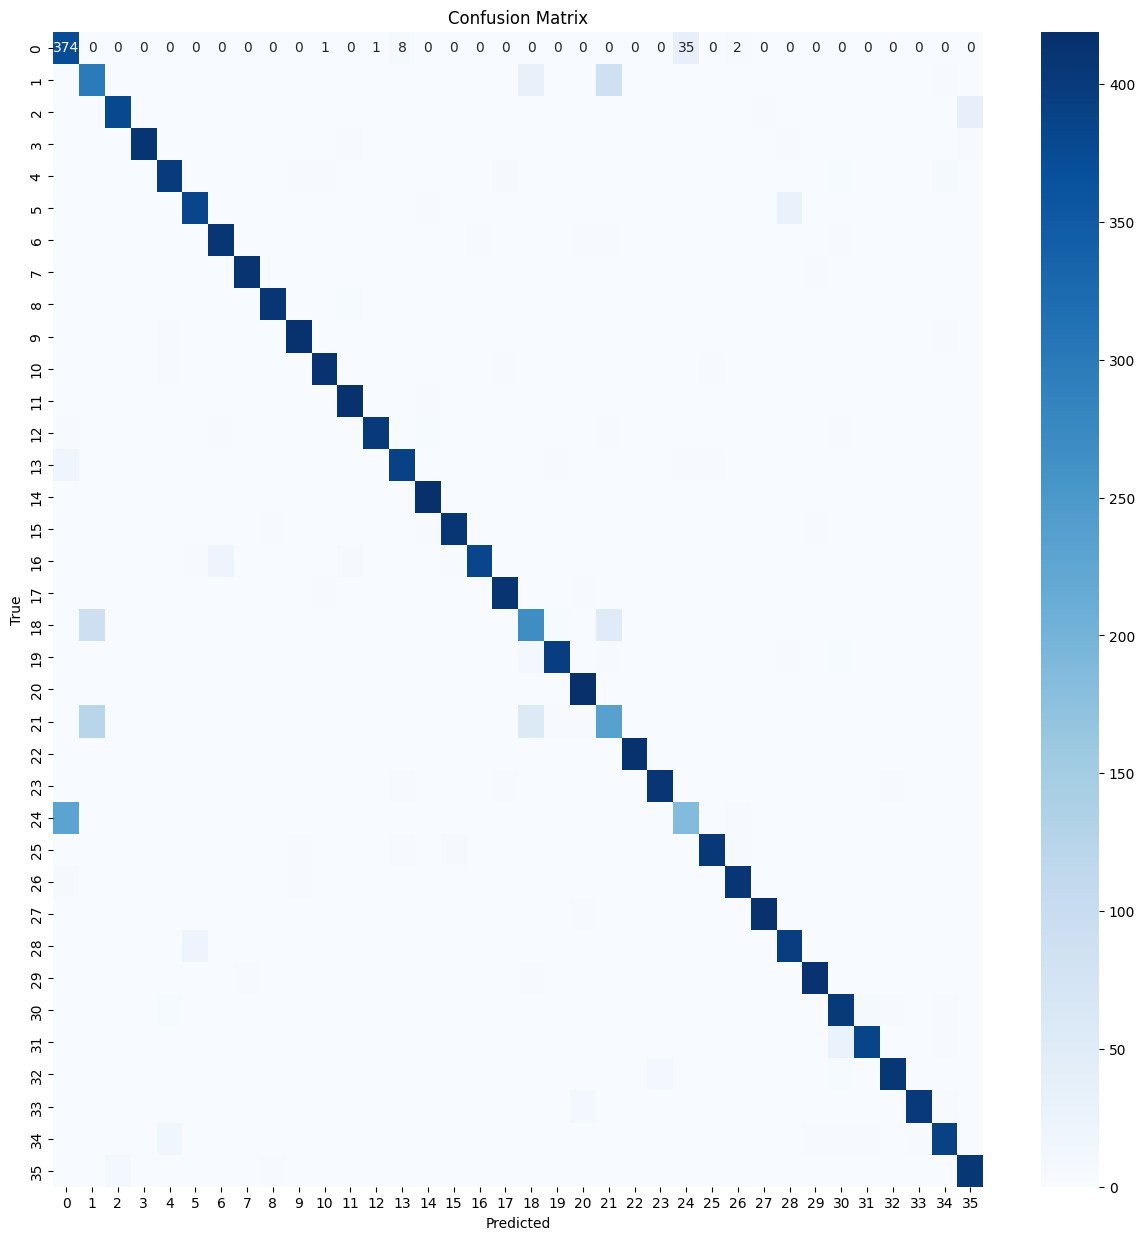

In [ ]:
# Visualizing Confusion Matrix

cm_dp3 = confusion_matrix(true_values_dp3, pred_values_dp3)
plt.figure(figsize=(15,15))
sns.heatmap(cm_dp3, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

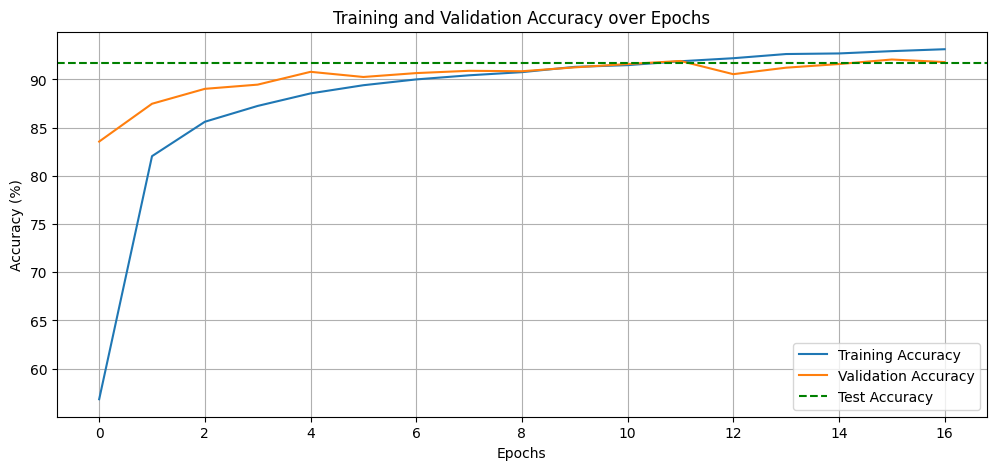

In [ ]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history_dp3, label='Training Accuracy')
plt.plot(val_accuracy_history_dp3, label='Validation Accuracy')
plt.axhline(y=(accuracy_dp3.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

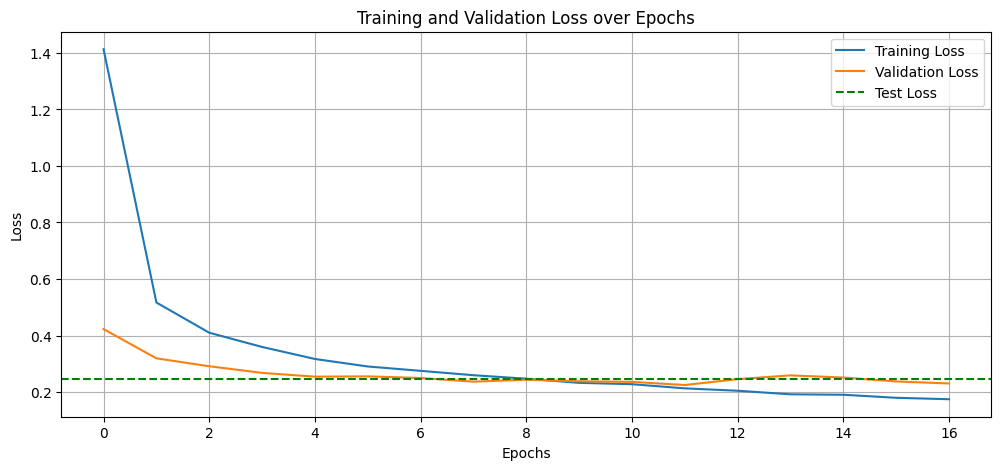

In [ ]:
# Losses Plot
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history_dp3, label='Training Loss')
plt.plot(val_loss_history_dp3, label='Validation Loss')
plt.axhline(y=test_loss_per_batch_dp3, color='g', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Setup-2 Trying Different Optimizers**

**sub-1(RMSProp)**

In [ ]:
# Initialize the model
cnn_op1 = CNN().to(device)
print(cnn_op1)

# Model summary
summary(cnn_op1, input_size=(3, 28, 28))

CNN(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5)

In [ ]:
# Selecting Cross Entropy Loss
criterion_op1 = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer_op1 = torch.optim.RMSprop(cnn_op1.parameters(), lr=0.001)

In [ ]:
# Training and evaluating test and validation sets

train_accuracy_history_op1, val_accuracy_history_op1 = [], []
train_loss_history_op1, val_loss_history_op1 = [], []

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss_op1 = float('inf')
no_improvement_count_op1 = 0

# Start train time
start_train_time_op1 = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    cnn_op1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer_op1.zero_grad()
        outputs = cnn_op1(images)
        loss = criterion_op1(outputs, labels)
        loss.backward()
        optimizer_op1.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    training_loss_per_batch_op1 = running_loss / len(train_loader)
    train_loss_history_op1.append(training_loss_per_batch_op1)
    train_accuracy_history_op1.append(100. * correct_train / total_train)

    cnn_op1.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_op1(images)
            val_loss += criterion_op1(outputs, labels).item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    validation_loss_per_batch_op1 = val_loss / len(val_loader)
    val_loss_history_op1.append(validation_loss_per_batch_op1)
    val_accuracy_history_op1.append(100. * correct_val / total_val)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch_op1}, Validation Loss: {validation_loss_per_batch_op1}")

    # Early stopping
    if validation_loss_per_batch_op1 < best_validation_loss_op1:
        best_validation_loss_op1 = validation_loss_per_batch_op1
        no_improvement_count_op1 = 0
    else:
        no_improvement_count_op1 += 1
        if no_improvement_count_op1 >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time_op1 = time.time()
total_training_time_op1 = end_train_time_op1 - start_train_time_op1

Loss for Epoch- 1: 
 Training Loss: 6.922674592956224, Validation Loss: 1.6848118276405735
Loss for Epoch- 2: 
 Training Loss: 1.3691813479534294, Validation Loss: 0.6828896783981002
Loss for Epoch- 3: 
 Training Loss: 0.8246050460801583, Validation Loss: 0.45243791828886804
Loss for Epoch- 4: 
 Training Loss: 0.5553272096085246, Validation Loss: 0.3494802514764191
Loss for Epoch- 5: 
 Training Loss: 0.40003411539453343, Validation Loss: 0.3020285920097156
Loss for Epoch- 6: 
 Training Loss: 0.3187868715197984, Validation Loss: 0.2530300229819131
Loss for Epoch- 7: 
 Training Loss: 0.2813888985913808, Validation Loss: 0.2681721319355699
Loss for Epoch- 8: 
 Training Loss: 0.25492371832394123, Validation Loss: 0.24228020354776697
Loss for Epoch- 9: 
 Training Loss: 0.23472791946680707, Validation Loss: 0.24818636295229135
Loss for Epoch- 10: 
 Training Loss: 0.22312015881880226, Validation Loss: 0.2373870616634924
Loss for Epoch- 11: 
 Training Loss: 0.20942415533665087, Validation Loss

In [ ]:
# Printing the model weights

print(f"Model state: {cnn_op1.state_dict()}")

Model state: OrderedDict([('conv1.weight', tensor([[[[ 1.5851e-01, -4.8908e-02, -1.7320e-01],
          [-2.8952e-02,  1.2404e-02, -5.9511e-03],
          [-5.2355e-03,  1.1556e-01,  2.3695e-01]],

         [[ 9.6000e-02,  1.5471e-01, -2.1754e-01],
          [ 1.9799e-01, -1.9787e-01, -8.0558e-02],
          [ 1.4297e-01, -4.9222e-02,  2.6825e-01]],

         [[-3.7498e-02,  6.1883e-02, -7.4100e-02],
          [-7.3130e-02, -1.7131e-04, -2.7543e-02],
          [ 2.0265e-01, -1.6885e-01,  2.3749e-01]]],


        [[[-5.0408e-02, -1.5988e-01, -1.8032e-01],
          [ 2.0486e-01, -3.1335e-02,  8.9738e-02],
          [ 1.4521e-01, -6.8480e-02,  1.9732e-01]],

         [[-1.5804e-01, -2.6134e-01,  1.4245e-02],
          [ 9.3359e-02, -1.2468e-01, -5.3788e-02],
          [ 2.6214e-02,  9.5755e-02,  1.4571e-01]],

         [[ 5.1550e-02, -1.3947e-01, -7.2832e-02],
          [ 4.2401e-02, -1.2209e-01, -6.1910e-02],
          [ 2.5906e-01,  1.5206e-01,  4.8851e-02]]],


        [[[-2.7316e-01,

In [ ]:
# Evaluating test dataset
test_loss_op1 = 0.0
total_test_op1 = 0
pred_values_op1 = []
true_values_op1 = []
accuracy_op1 = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_op1(images)
        test_loss_op1 += criterion_op1(outputs, labels).item()
        _, predicted = outputs.max(1)
        total_test_op1 += labels.size(0)

        accuracy_op1(predicted, labels)

        # append predictions and true values
        pred_values_op1.extend(predicted.cpu().numpy())
        true_values_op1.extend(labels.cpu().numpy())

test_loss_per_batch_op1 = test_loss_op1 / len(test_loader)

In [ ]:
# calculate the evaluation metrices
precision_op1 = precision_score(true_values_op1, pred_values_op1, average='macro')
recall_op1 = recall_score(true_values_op1, pred_values_op1, average='macro')
f1_op1 = f1_score(true_values_op1, pred_values_op1, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time_op1:.4f} seconds")
print(f"Accuracy: {accuracy_op1.compute():.4f}")
print(f"Precision: {precision_op1:.4f}")
print(f"Recall: {recall_op1:.4f}")
print(f"F1 Score: {f1_op1:.4f}")

Time to train: 1468.1417 seconds
Accuracy: 0.9200
Precision: 0.9234
Recall: 0.9200
F1 Score: 0.9195


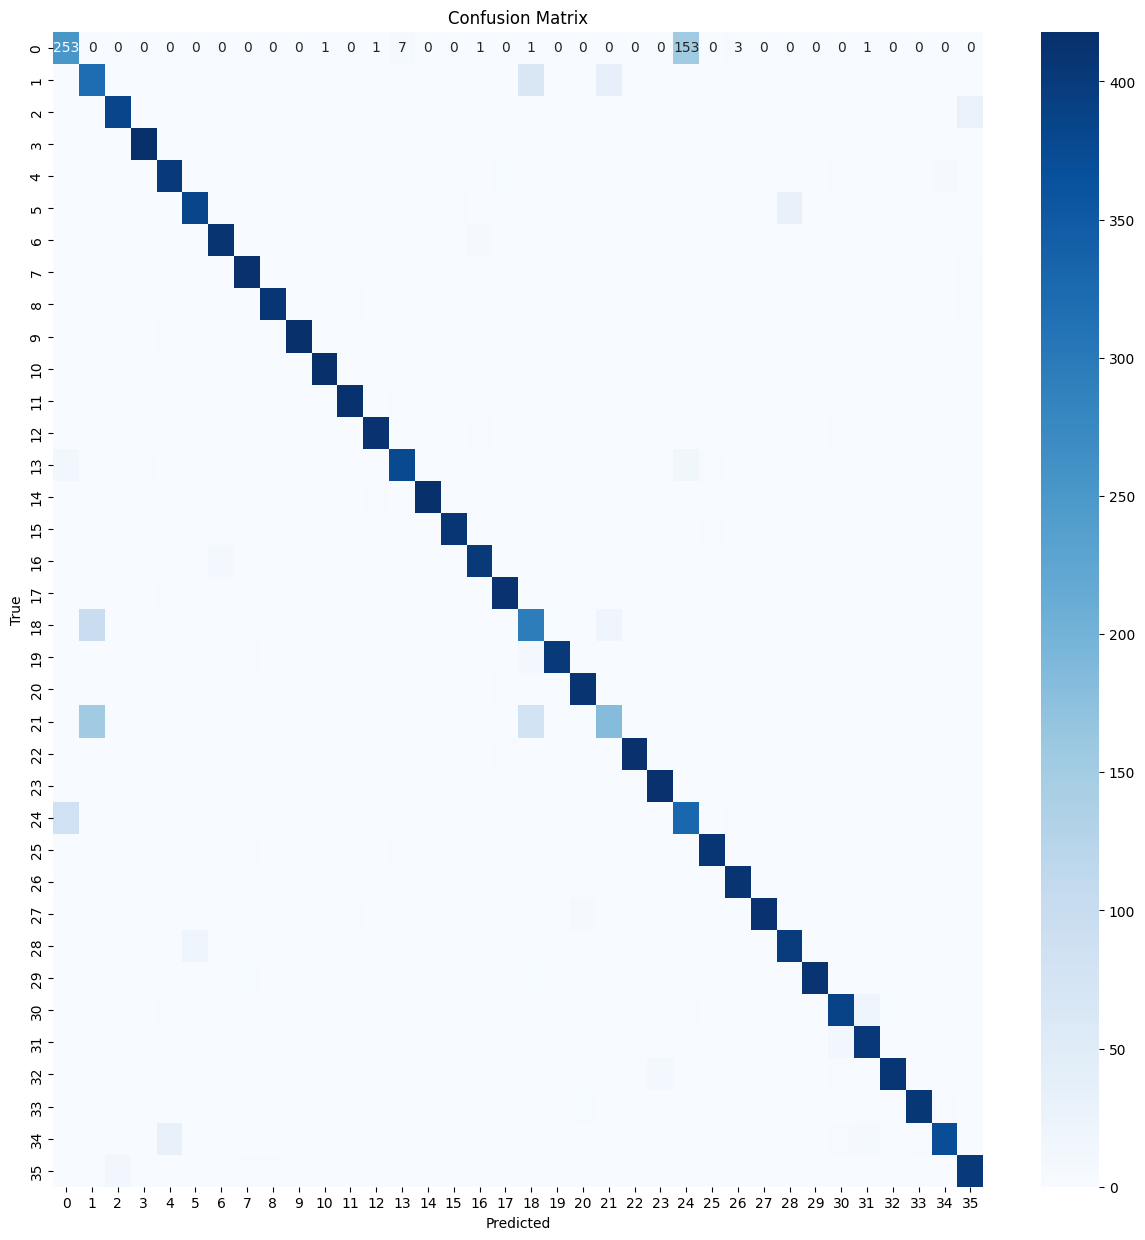

In [ ]:
# Visualizing Confusion Matrix

cm_op1 = confusion_matrix(true_values_op1, pred_values_op1)
plt.figure(figsize=(15,15))
sns.heatmap(cm_op1, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

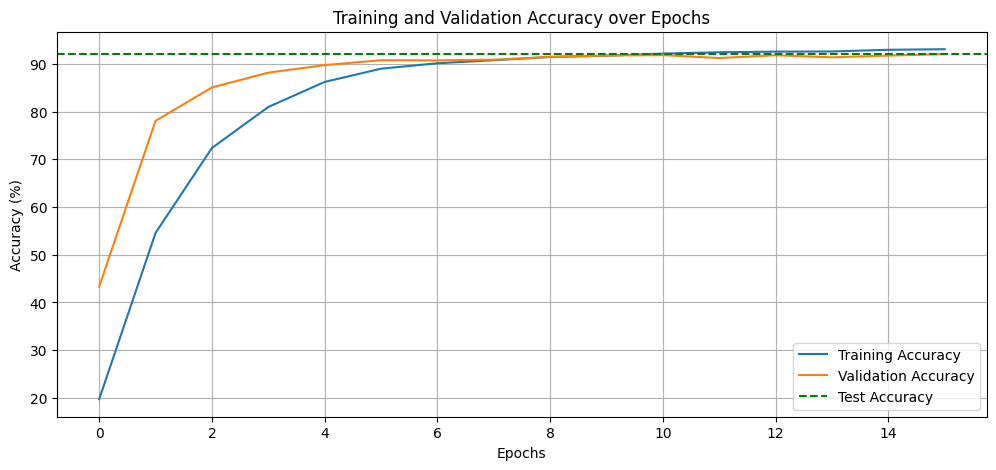

In [ ]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history_op1, label='Training Accuracy')
plt.plot(val_accuracy_history_op1, label='Validation Accuracy')
plt.axhline(y=(accuracy_op1.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

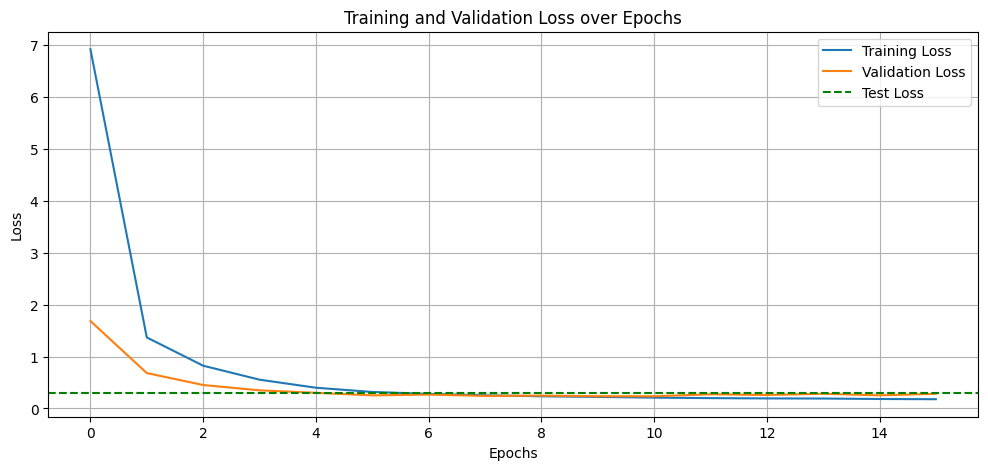

In [ ]:
# Losses Plot
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history_op1, label='Training Loss')
plt.plot(val_loss_history_op1, label='Validation Loss')
plt.axhline(y=test_loss_per_batch_op1, color='g', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**sub-2(AdamW)**

In [ ]:
# Initialize the model
cnn_op2 = CNN().to(device)
print(cnn_op2)

# Model summary
summary(cnn_op2, input_size=(3, 28, 28))

CNN(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5)

In [ ]:
# Selecting Cross Entropy Loss
criterion_op2 = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer_op2 = torch.optim.AdamW(cnn_op2.parameters(), lr=0.001)

In [ ]:
# Training and evaluating test and validation sets

train_accuracy_history_op2, val_accuracy_history_op2 = [], []
train_loss_history_op2, val_loss_history_op2 = [], []

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss_op2 = float('inf')
no_improvement_count_op2 = 0

# Start train time
start_train_time_op2 = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    cnn_op2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer_op2.zero_grad()
        outputs = cnn_op2(images)
        loss = criterion_op2(outputs, labels)
        loss.backward()
        optimizer_op2.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    training_loss_per_batch_op2 = running_loss / len(train_loader)
    train_loss_history_op2.append(training_loss_per_batch_op2)
    train_accuracy_history_op2.append(100. * correct_train / total_train)

    cnn_op2.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_op2(images)
            val_loss += criterion_op2(outputs, labels).item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    validation_loss_per_batch_op2 = val_loss / len(val_loader)
    val_loss_history_op2.append(validation_loss_per_batch_op2)
    val_accuracy_history_op2.append(100. * correct_val / total_val)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch_op2}, Validation Loss: {validation_loss_per_batch_op2}")

    # Early stopping
    if validation_loss_per_batch_op2 < best_validation_loss_op2:
        best_validation_loss_op2 = validation_loss_per_batch_op2
        no_improvement_count_op2 = 0
    else:
        no_improvement_count_op2 += 1
        if no_improvement_count_op2 >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time_op2 = time.time()
total_training_time_op2 = end_train_time_op2 - start_train_time_op2

Loss for Epoch- 1: 
 Training Loss: 1.3755509229731864, Validation Loss: 0.4544622430405697
Loss for Epoch- 2: 
 Training Loss: 0.5574582027923822, Validation Loss: 0.3280746104712246
Loss for Epoch- 3: 
 Training Loss: 0.4278622915708002, Validation Loss: 0.32331305936745863
Loss for Epoch- 4: 
 Training Loss: 0.3647685551275575, Validation Loss: 0.25917295967972204
Loss for Epoch- 5: 
 Training Loss: 0.32792144813684715, Validation Loss: 0.2485394108318528
Loss for Epoch- 6: 
 Training Loss: 0.2996384353392137, Validation Loss: 0.2872144677999093
Loss for Epoch- 7: 
 Training Loss: 0.27718822105015256, Validation Loss: 0.2370803712132512
Loss for Epoch- 8: 
 Training Loss: 0.26082571705434804, Validation Loss: 0.2525946445363973
Loss for Epoch- 9: 
 Training Loss: 0.24709753175612587, Validation Loss: 0.24120242893182234
Loss for Epoch- 10: 
 Training Loss: 0.22879070381611966, Validation Loss: 0.22916700837665585
Loss for Epoch- 11: 
 Training Loss: 0.22046316579362873, Validation L

In [ ]:
# Printing the model weights

print(f"Model state: {cnn_op2.state_dict()}")

Model state: OrderedDict([('conv1.weight', tensor([[[[ 0.1036,  0.0441, -0.1004],
          [-0.0937,  0.0528, -0.2188],
          [-0.0523,  0.0802, -0.0587]],

         [[ 0.2117,  0.1751,  0.0275],
          [ 0.0309,  0.1314, -0.1794],
          [ 0.0249,  0.0013, -0.2240]],

         [[-0.0039, -0.0579, -0.1895],
          [ 0.0156, -0.0843, -0.0802],
          [ 0.1625, -0.0593, -0.2132]]],


        [[[-0.0964,  0.0990,  0.1832],
          [ 0.0503, -0.2176,  0.2177],
          [ 0.1604, -0.1335,  0.0363]],

         [[ 0.0258, -0.1590,  0.0979],
          [-0.0919, -0.2576, -0.0501],
          [ 0.1076,  0.0498, -0.1456]],

         [[-0.1006, -0.1128,  0.0759],
          [ 0.0193, -0.1202, -0.0766],
          [ 0.0511, -0.1405, -0.1289]]],


        [[[ 0.1101, -0.0820,  0.1366],
          [ 0.2072,  0.0042, -0.1839],
          [-0.0570,  0.0473, -0.2625]],

         [[-0.1375,  0.1297, -0.0739],
          [ 0.0036, -0.0021, -0.0155],
          [ 0.1093, -0.0873,  0.0028]],

 

In [ ]:
# Evaluating test dataset
test_loss_op2 = 0.0
total_test_op2 = 0
pred_values_op2 = []
true_values_op2 = []
accuracy_op2 = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_op2(images)
        test_loss_op2 += criterion_op2(outputs, labels).item()
        _, predicted = outputs.max(1)
        total_test_op2 += labels.size(0)

        accuracy_op2(predicted, labels)

        # append predictions and true values
        pred_values_op2.extend(predicted.cpu().numpy())
        true_values_op2.extend(labels.cpu().numpy())

test_loss_per_batch_op2 = test_loss_op2 / len(test_loader)

In [ ]:
# calculate the evaluation metrices
precision_op2 = precision_score(true_values_op2, pred_values_op2, average='macro')
recall_op2 = recall_score(true_values_op2, pred_values_op2, average='macro')
f1_op2 = f1_score(true_values_op2, pred_values_op2, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time_op2:.4f} seconds")
print(f"Accuracy: {accuracy_op2.compute():.4f}")
print(f"Precision: {precision_op2:.4f}")
print(f"Recall: {recall_op2:.4f}")
print(f"F1 Score: {f1_op2:.4f}")

Time to train: 1495.0724 seconds
Accuracy: 0.9151
Precision: 0.9173
Recall: 0.9151
F1 Score: 0.9151


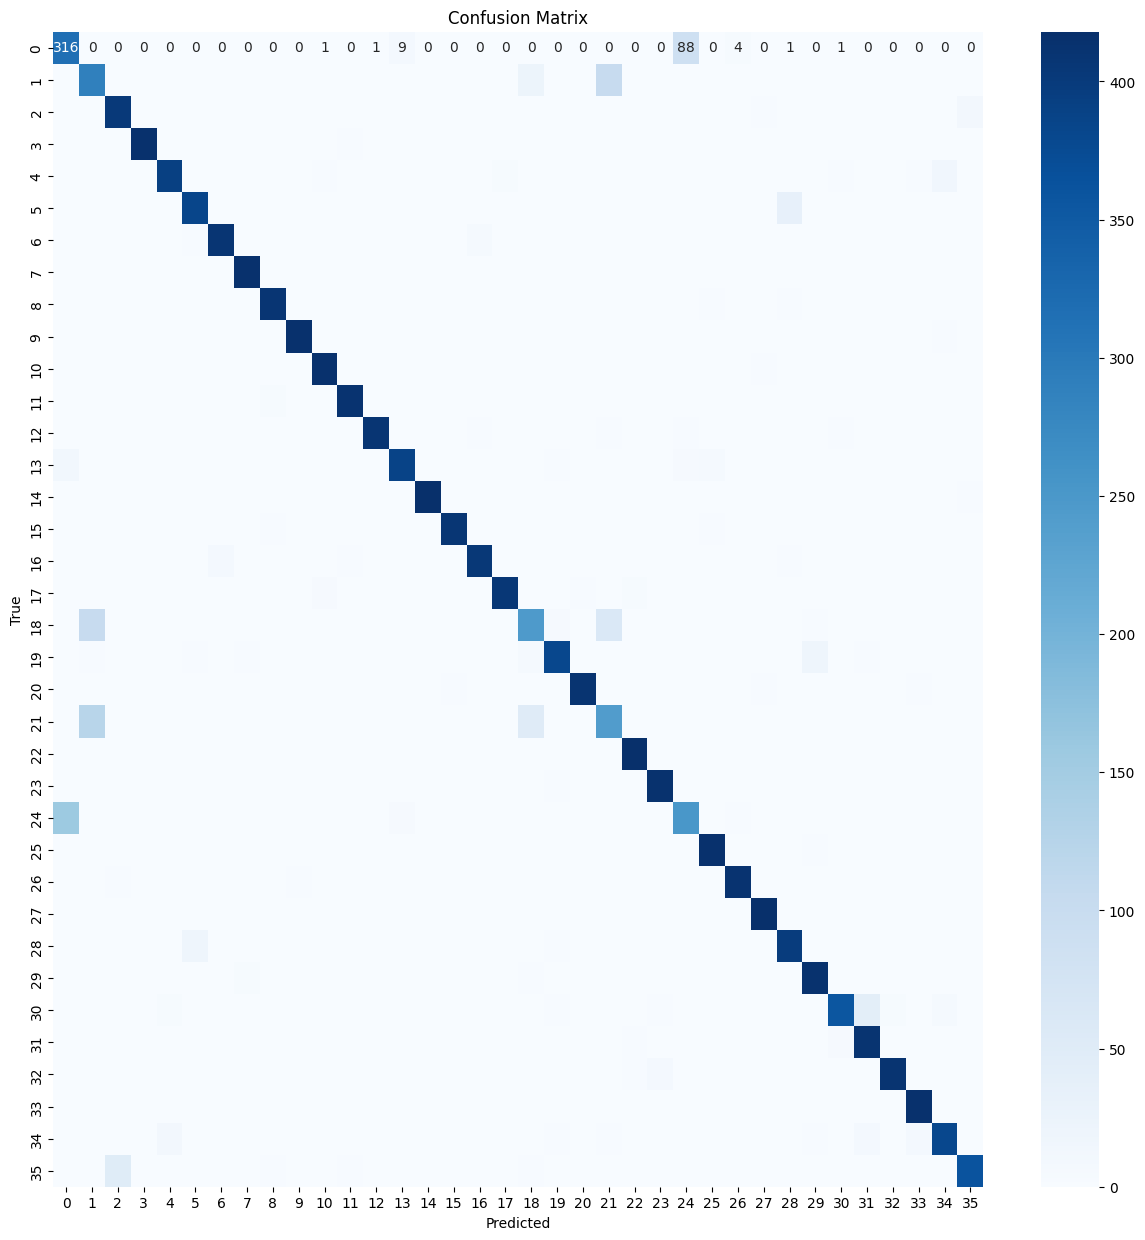

In [ ]:
# Visualizing Confusion Matrix

cm_op2 = confusion_matrix(true_values_op2, pred_values_op2)
plt.figure(figsize=(15,15))
sns.heatmap(cm_op2, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

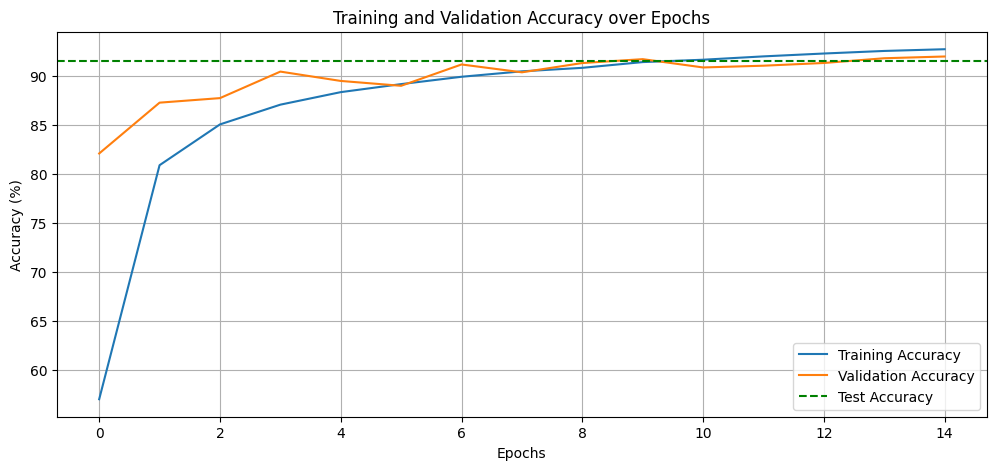

In [ ]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history_op2, label='Training Accuracy')
plt.plot(val_accuracy_history_op2, label='Validation Accuracy')
plt.axhline(y=(accuracy_op2.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

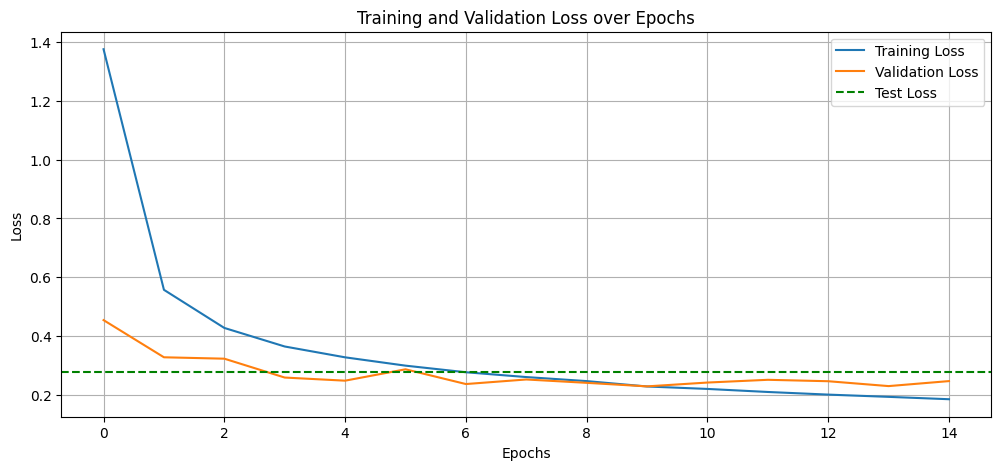

In [ ]:
# Losses Plot
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history_op2, label='Training Loss')
plt.plot(val_loss_history_op2, label='Validation Loss')
plt.axhline(y=test_loss_per_batch_op2, color='g', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Sub-3(SGD)**

In [ ]:
# Initialize the model
cnn_op3 = CNN().to(device)
print(cnn_op3)

# Model summary
summary(cnn_op3, input_size=(3, 28, 28))

CNN(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5)

In [ ]:
# Selecting Cross Entropy Loss
criterion_op3 = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer_op3 = torch.optim.SGD(cnn_op3.parameters(), lr=0.001)

In [ ]:
# Training and evaluating test and validation sets

train_accuracy_history_op3, val_accuracy_history_op3 = [], []
train_loss_history_op3, val_loss_history_op3 = [], []

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss_op3 = float('inf')
no_improvement_count_op3 = 0

# Start train time
start_train_time_op3 = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    cnn_op3.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer_op3.zero_grad()
        outputs = cnn_op3(images)
        loss = criterion_op3(outputs, labels)
        loss.backward()
        optimizer_op3.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    training_loss_per_batch_op3 = running_loss / len(train_loader)
    train_loss_history_op3.append(training_loss_per_batch_op3)
    train_accuracy_history_op3.append(100. * correct_train / total_train)

    cnn_op3.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_op3(images)
            val_loss += criterion_op3(outputs, labels).item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    validation_loss_per_batch_op3 = val_loss / len(val_loader)
    val_loss_history_op3.append(validation_loss_per_batch_op3)
    val_accuracy_history_op3.append(100. * correct_val / total_val)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch_op3}, Validation Loss: {validation_loss_per_batch_op3}")

    # Early stopping
    if validation_loss_per_batch_op3 < best_validation_loss_op3:
        best_validation_loss_op3 = validation_loss_per_batch_op3
        no_improvement_count_op3 = 0
    else:
        no_improvement_count_op3 += 1
        if no_improvement_count_op3 >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time_op3 = time.time()
total_training_time_op3 = end_train_time_op3 - start_train_time_op3

Loss for Epoch- 1: 
 Training Loss: 3.2993821405455765, Validation Loss: 2.6911554276442327
Loss for Epoch- 2: 
 Training Loss: 2.0856316550457326, Validation Loss: 1.1805635881023246
Loss for Epoch- 3: 
 Training Loss: 1.0950373043382233, Validation Loss: 0.6839393457444776
Loss for Epoch- 4: 
 Training Loss: 0.7476339618220736, Validation Loss: 0.5165660293663249
Loss for Epoch- 5: 
 Training Loss: 0.5984313346296819, Validation Loss: 0.43885039632059947
Loss for Epoch- 6: 
 Training Loss: 0.5130872107677148, Validation Loss: 0.3895599297365221
Loss for Epoch- 7: 
 Training Loss: 0.45899836213316114, Validation Loss: 0.35710629557862
Loss for Epoch- 8: 
 Training Loss: 0.4210042375834581, Validation Loss: 0.33436180951715516
Loss for Epoch- 9: 
 Training Loss: 0.38827238901232636, Validation Loss: 0.31807695742414777
Loss for Epoch- 10: 
 Training Loss: 0.36605920021958016, Validation Loss: 0.3033187091663605
Loss for Epoch- 11: 
 Training Loss: 0.3492764912532159, Validation Loss: 0

In [ ]:
# Evaluating test dataset
test_loss_op3 = 0.0
total_test_op3 = 0
pred_values_op3 = []
true_values_op3 = []
accuracy_op3 = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_op3(images)
        test_loss_op3 += criterion_op3(outputs, labels).item()
        _, predicted = outputs.max(1)
        total_test_op3 += labels.size(0)

        accuracy_op3(predicted, labels)

        # append predictions and true values
        pred_values_op3.extend(predicted.cpu().numpy())
        true_values_op3.extend(labels.cpu().numpy())

test_loss_per_batch_op3 = test_loss_op3 / len(test_loader)

In [ ]:
# calculate the evaluation metrices
precision_op3 = precision_score(true_values_op3, pred_values_op3, average='macro')
recall_op3 = recall_score(true_values_op3, pred_values_op3, average='macro')
f1_op3 = f1_score(true_values_op3, pred_values_op3, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time_op3:.4f} seconds")
print(f"Accuracy: {accuracy_op3.compute():.4f}")
print(f"Precision: {precision_op3:.4f}")
print(f"Recall: {recall_op3:.4f}")
print(f"F1 Score: {f1_op3:.4f}")

Time to train: 4162.7161 seconds
Accuracy: 0.9151
Precision: 0.9160
Recall: 0.9151
F1 Score: 0.9148


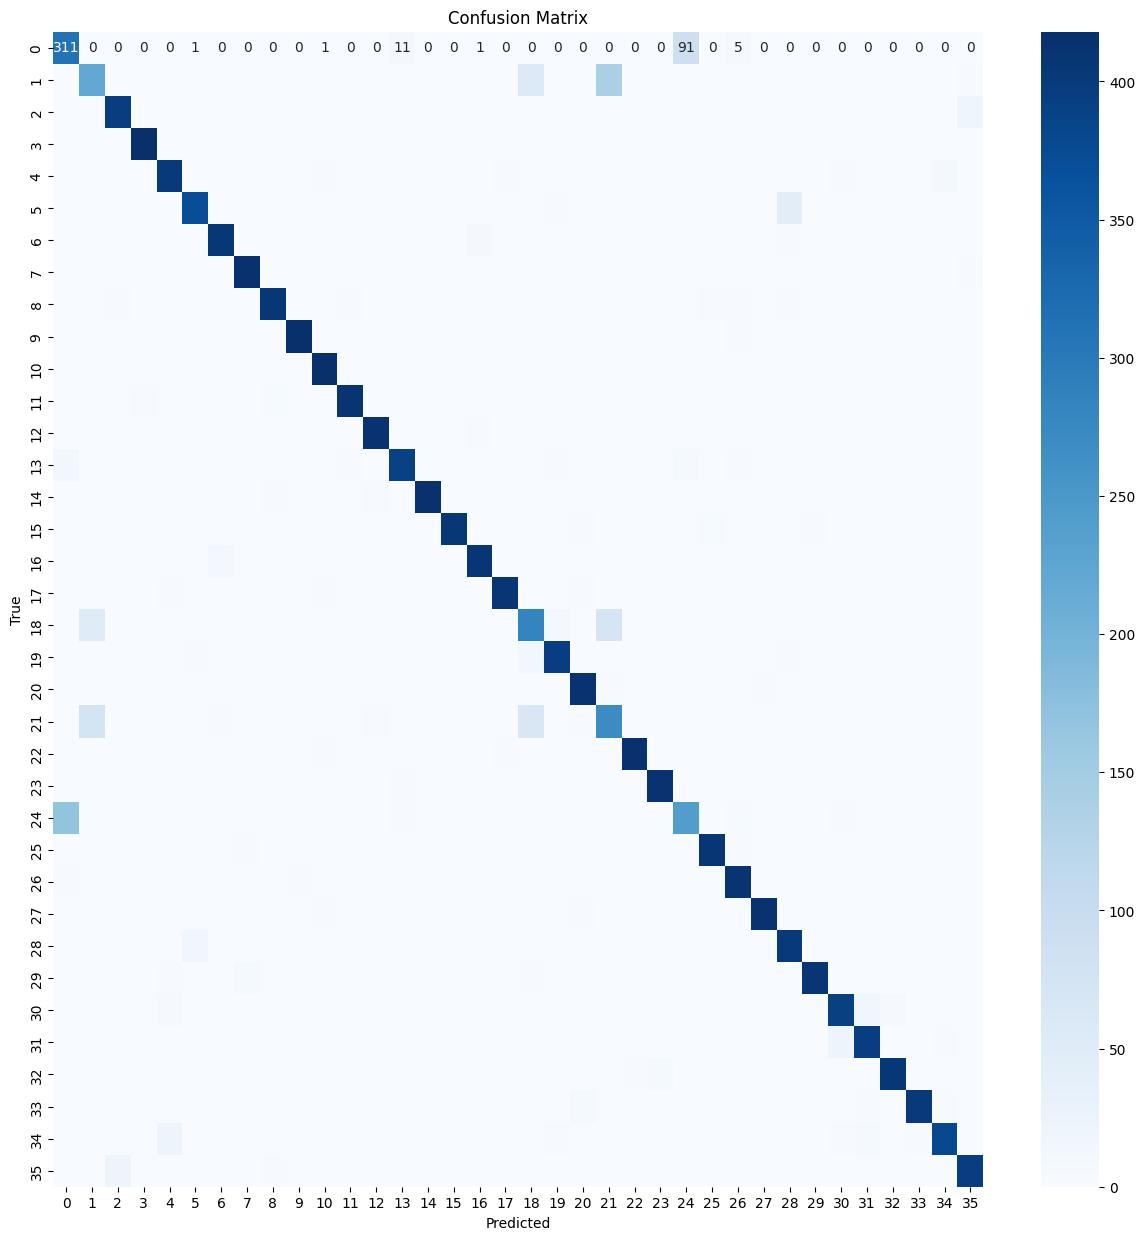

In [ ]:
# Visualizing Confusion Matrix

cm_op3 = confusion_matrix(true_values_op3, pred_values_op3)
plt.figure(figsize=(15,15))
sns.heatmap(cm_op3, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

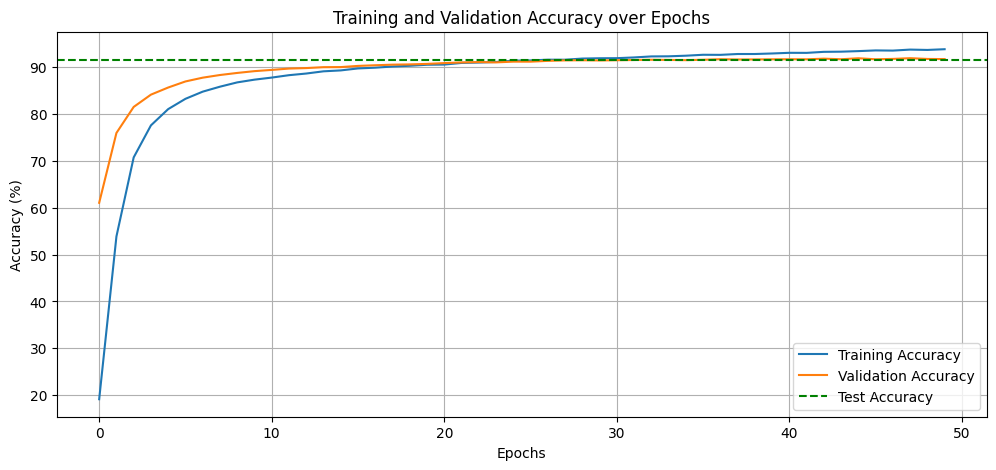

In [ ]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history_op3, label='Training Accuracy')
plt.plot(val_accuracy_history_op3, label='Validation Accuracy')
plt.axhline(y=(accuracy_op3.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Setup-3(Trying different activation functions)**

**sub-1(LeakyReLU)**

In [ ]:
# Initialize the model
cnn_ac1 = CNN(activation_function = nn.LeakyReLU(negative_slope = 0.01)).to(device)
print(cnn_ac1)

# Model summary
summary(cnn_ac1, input_size=(3, 28, 28))

CNN(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slop

In [ ]:
# Selecting Cross Entropy Loss
criterion_ac1 = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer_ac1 = torch.optim.Adam(cnn_ac1.parameters(), lr=0.001)

In [ ]:
# Training and evaluating test and validation sets

train_accuracy_history_ac1, val_accuracy_history_ac1 = [], []
train_loss_history_ac1, val_loss_history_ac1 = [], []

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss_ac1 = float('inf')
no_improvement_count_ac1 = 0

# Start train time
start_train_time_ac1 = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    cnn_ac1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer_ac1.zero_grad()
        outputs = cnn_ac1(images)
        loss = criterion_ac1(outputs, labels)
        loss.backward()
        optimizer_ac1.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    training_loss_per_batch_ac1 = running_loss / len(train_loader)
    train_loss_history_ac1.append(training_loss_per_batch_ac1)
    train_accuracy_history_ac1.append(100. * correct_train / total_train)

    cnn_ac1.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_ac1(images)
            val_loss += criterion_ac1(outputs, labels).item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    validation_loss_per_batch_ac1 = val_loss / len(val_loader)
    val_loss_history_ac1.append(validation_loss_per_batch_ac1)
    val_accuracy_history_ac1.append(100. * correct_val / total_val)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch_ac1}, Validation Loss: {validation_loss_per_batch_ac1}")

    # Early stopping
    if validation_loss_per_batch_ac1 < best_validation_loss_ac1:
        best_validation_loss_ac1 = validation_loss_per_batch_ac1
        no_improvement_count_ac1 = 0
    else:
        no_improvement_count_ac1 += 1
        if no_improvement_count_ac1 >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time_ac1 = time.time()
total_training_time_ac1 = end_train_time_ac1 - start_train_time_ac1

Loss for Epoch- 1: 
 Training Loss: 1.2865891795193003, Validation Loss: 0.45488193072378635
Loss for Epoch- 2: 
 Training Loss: 0.47488870313509407, Validation Loss: 0.3279064624734661
Loss for Epoch- 3: 
 Training Loss: 0.37699560391059156, Validation Loss: 0.3100858128027004
Loss for Epoch- 4: 
 Training Loss: 0.32146270863860577, Validation Loss: 0.2602559983213784
Loss for Epoch- 5: 
 Training Loss: 0.28477661367066326, Validation Loss: 0.2654863751856336
Loss for Epoch- 6: 
 Training Loss: 0.2627687833919283, Validation Loss: 0.2548304427759487
Loss for Epoch- 7: 
 Training Loss: 0.2520977353200506, Validation Loss: 0.23925781279886454
Loss for Epoch- 8: 
 Training Loss: 0.23516695808531368, Validation Loss: 0.258278937392062
Loss for Epoch- 9: 
 Training Loss: 0.23130243139074416, Validation Loss: 0.23467469223023651
Loss for Epoch- 10: 
 Training Loss: 0.22446818560524126, Validation Loss: 0.22338260396884094
Loss for Epoch- 11: 
 Training Loss: 0.21211216959784554, Validation 

In [ ]:
# Printing the model weights

print(f"Model state: {cnn_ac1.state_dict()}")

Model state: OrderedDict([('conv1.weight', tensor([[[[-0.1899, -0.0091,  0.1420],
          [ 0.1623,  0.2191,  0.0522],
          [-0.1473,  0.1184, -0.2457]],

         [[ 0.1355, -0.0928, -0.0023],
          [ 0.0030,  0.1482, -0.0014],
          [-0.2534,  0.1223,  0.0330]],

         [[ 0.0640, -0.0953, -0.1562],
          [-0.0577, -0.0139,  0.0450],
          [-0.0616,  0.1911, -0.0864]]],


        [[[ 0.0153,  0.1133,  0.1424],
          [ 0.0726, -0.0054, -0.1253],
          [-0.1668,  0.1644, -0.2255]],

         [[-0.0218, -0.0155, -0.0762],
          [-0.1780,  0.1982, -0.0817],
          [ 0.0219,  0.2128, -0.0406]],

         [[-0.0095,  0.0289, -0.1778],
          [-0.0927,  0.2621,  0.0226],
          [-0.0675,  0.2089, -0.1776]]],


        [[[ 0.1915,  0.1696, -0.1041],
          [ 0.1682, -0.0989,  0.0509],
          [-0.0697, -0.1151,  0.1952]],

         [[ 0.0153,  0.0152, -0.1650],
          [-0.0096, -0.2252,  0.1271],
          [-0.2189, -0.0240,  0.1253]],

 

In [ ]:
# Evaluating test dataset
test_loss_ac1 = 0.0
total_test_ac1 = 0
pred_values_ac1 = []
true_values_ac1 = []
accuracy_ac1 = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_ac1(images)
        test_loss_ac1 += criterion_ac1(outputs, labels).item()
        _, predicted = outputs.max(1)
        total_test_ac1 += labels.size(0)

        accuracy_ac1(predicted, labels)

        # append predictions and true values
        pred_values_ac1.extend(predicted.cpu().numpy())
        true_values_ac1.extend(labels.cpu().numpy())

test_loss_per_batch_ac1 = test_loss_ac1 / len(test_loader)

In [ ]:
# calculate the evaluation metrices
precision_ac1 = precision_score(true_values_ac1, pred_values_ac1, average='macro')
recall_ac1 = recall_score(true_values_ac1, pred_values_ac1, average='macro')
f1_ac1 = f1_score(true_values_ac1, pred_values_ac1, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time_ac1:.4f} seconds")
print(f"Accuracy: {accuracy_ac1.compute():.4f}")
print(f"Precision: {precision_ac1:.4f}")
print(f"Recall: {recall_ac1:.4f}")
print(f"F1 Score: {f1_ac1:.4f}")

Time to train: 1672.8648 seconds
Accuracy: 0.9122
Precision: 0.9163
Recall: 0.9122
F1 Score: 0.9126


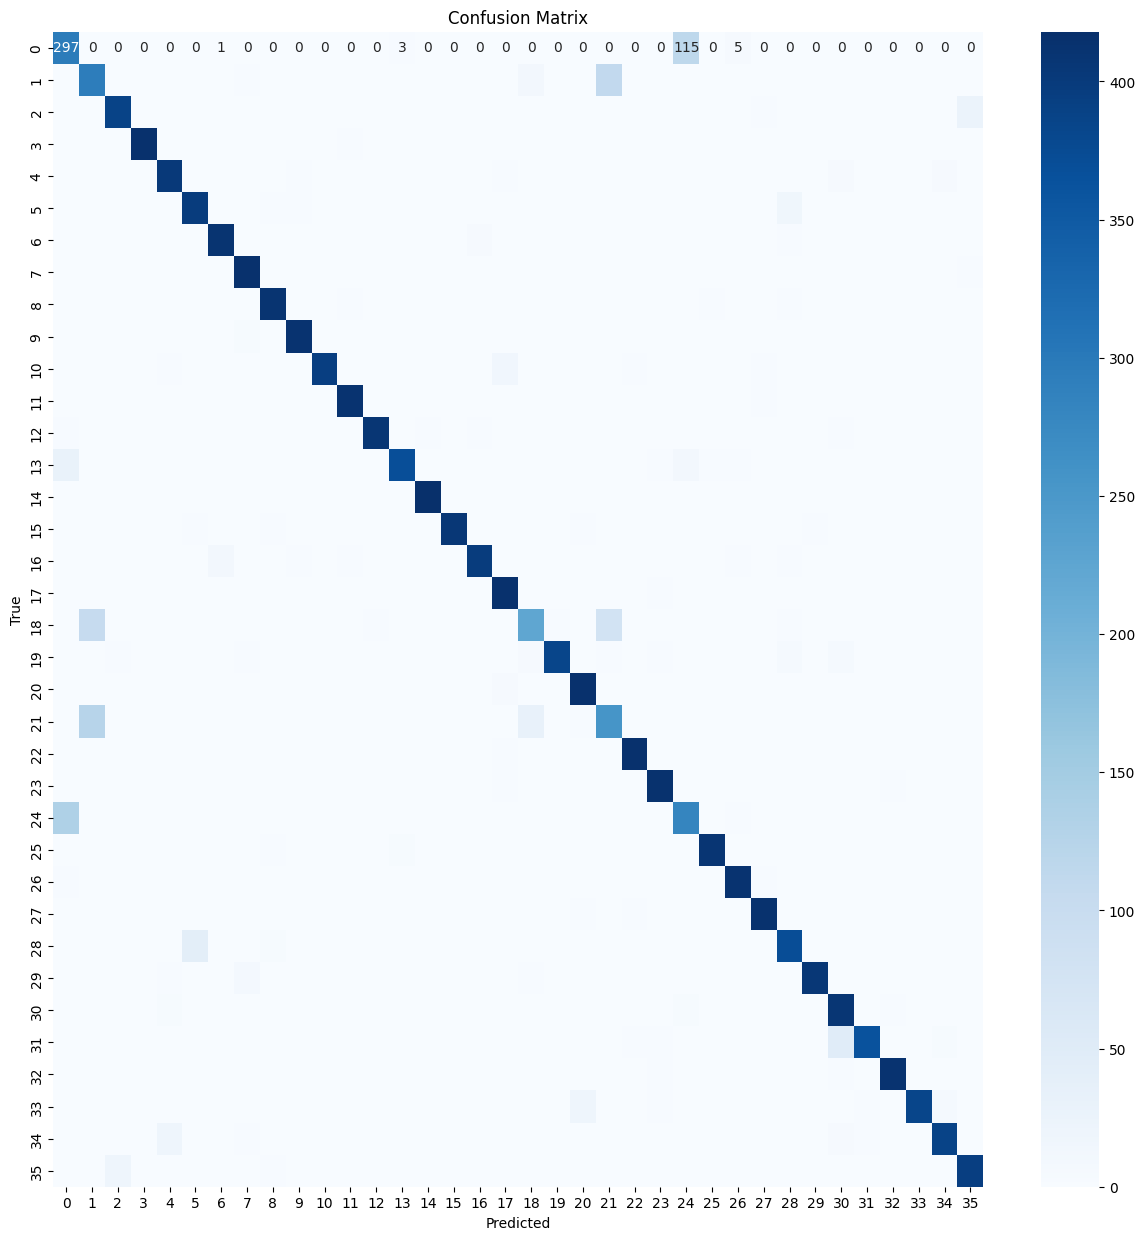

In [ ]:
# Visualizing Confusion Matrix

cm_ac1 = confusion_matrix(true_values_ac1, pred_values_ac1)
plt.figure(figsize=(15,15))
sns.heatmap(cm_ac1, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

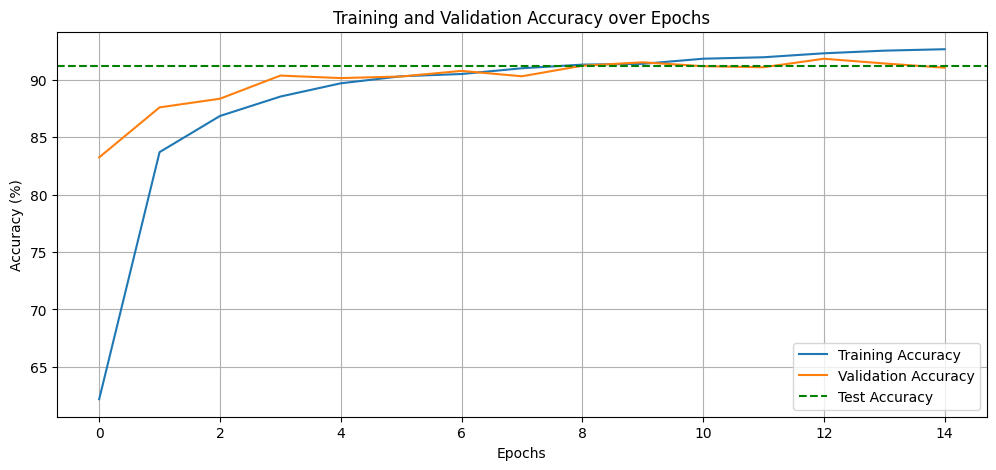

In [ ]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history_ac1, label='Training Accuracy')
plt.plot(val_accuracy_history_ac1, label='Validation Accuracy')
plt.axhline(y=(accuracy_ac1.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

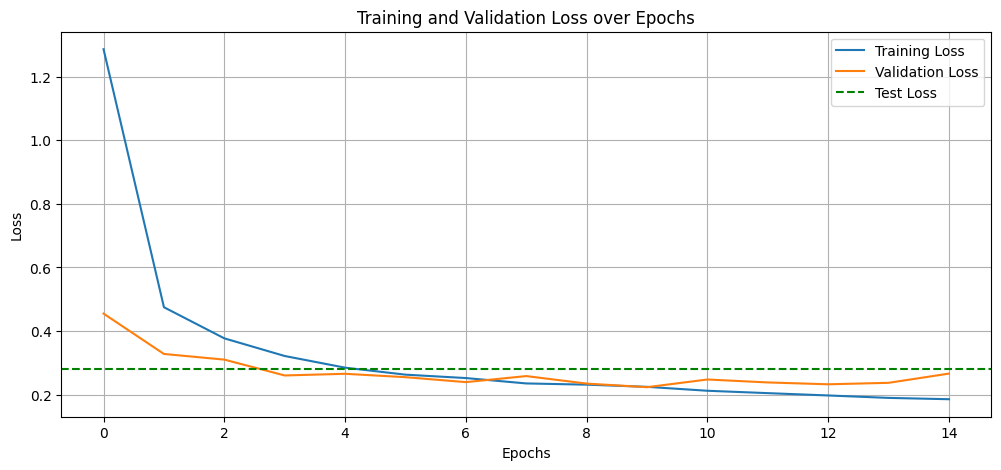

In [ ]:
# Losses Plot
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history_ac1, label='Training Loss')
plt.plot(val_loss_history_ac1, label='Validation Loss')
plt.axhline(y=test_loss_per_batch_ac1, color='g', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**sub-2(ELU)**

In [ ]:
# Initialize the model
cnn_ac2 = CNN(activation_function = nn.ELU()).to(device)
print(cnn_ac2)

# Model summary
summary(cnn_ac2, input_size=(3, 28, 28))

CNN(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ELU(alpha=1.0)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ELU(alpha=1.0)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ELU(alpha=1.0)
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ELU(alpha=1.0)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(

In [ ]:
# Selecting Cross Entropy Loss
criterion_ac2 = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer_ac2 = torch.optim.Adam(cnn_ac2.parameters(), lr=0.001)

In [ ]:
# Training and evaluating test and validation sets

train_accuracy_history_ac2, val_accuracy_history_ac2 = [], []
train_loss_history_ac2, val_loss_history_ac2 = [], []

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss_ac2 = float('inf')
no_improvement_count_ac2 = 0

# Start train time
start_train_time_ac2 = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    cnn_ac2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer_ac2.zero_grad()
        outputs = cnn_ac2(images)
        loss = criterion_ac2(outputs, labels)
        loss.backward()
        optimizer_ac2.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    training_loss_per_batch_ac2 = running_loss / len(train_loader)
    train_loss_history_ac2.append(training_loss_per_batch_ac2)
    train_accuracy_history_ac2.append(100. * correct_train / total_train)

    cnn_ac2.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_ac2(images)
            val_loss += criterion_ac2(outputs, labels).item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    validation_loss_per_batch_ac2 = val_loss / len(val_loader)
    val_loss_history_ac2.append(validation_loss_per_batch_ac2)
    val_accuracy_history_ac2.append(100. * correct_val / total_val)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch_ac2}, Validation Loss: {validation_loss_per_batch_ac2}")

    # Early stopping
    if validation_loss_per_batch_ac2 < best_validation_loss_ac2:
        best_validation_loss_ac2 = validation_loss_per_batch_ac2
        no_improvement_count_ac2 = 0
    else:
        no_improvement_count_ac2 += 1
        if no_improvement_count_ac2 >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time_ac2 = time.time()
total_training_time_ac2 = end_train_time_ac2 - start_train_time_ac2

Loss for Epoch- 1: 
 Training Loss: 1.5495518038147373, Validation Loss: 0.6395302126888468
Loss for Epoch- 2: 
 Training Loss: 0.8069836472967359, Validation Loss: 0.5479683898420644
Loss for Epoch- 3: 
 Training Loss: 0.752241185702343, Validation Loss: 0.5932345375215181
Loss for Epoch- 4: 
 Training Loss: 0.738742095534901, Validation Loss: 0.5720303899710294
Loss for Epoch- 5: 
 Training Loss: 0.7335019199525812, Validation Loss: 0.47324942968340156
Loss for Epoch- 6: 
 Training Loss: 0.7769079795766439, Validation Loss: 0.45926167082953506
Loss for Epoch- 7: 
 Training Loss: 0.7639337414081213, Validation Loss: 0.4846520184467327
Loss for Epoch- 8: 
 Training Loss: 0.7488947590769095, Validation Loss: 0.5136588602863259
Loss for Epoch- 9: 
 Training Loss: 0.7152675631745108, Validation Loss: 0.5371232566496107
Loss for Epoch- 10: 
 Training Loss: 0.7433195602818107, Validation Loss: 0.5358731543479857
Loss for Epoch- 11: 
 Training Loss: 0.7017652531933655, Validation Loss: 0.658

In [ ]:
# Printing the model weights

print(f"Model state: {cnn_ac2.state_dict()}")

Model state: OrderedDict([('conv1.weight', tensor([[[[ 0.0510, -0.0576,  0.1261],
          [-0.0767,  0.2186, -0.0063],
          [-0.1674,  0.0531,  0.0716]],

         [[ 0.1450,  0.1121, -0.2365],
          [-0.0107,  0.1322,  0.0633],
          [-0.0454,  0.1362, -0.0042]],

         [[-0.1524,  0.1979, -0.1771],
          [-0.1987,  0.1709, -0.1919],
          [ 0.0085, -0.0980, -0.0509]]],


        [[[-0.1035, -0.1202,  0.0634],
          [-0.0173, -0.0212,  0.0143],
          [ 0.0909,  0.1457,  0.0965]],

         [[-0.1144, -0.2453, -0.0897],
          [-0.1469, -0.1069,  0.2346],
          [-0.1979,  0.1589,  0.1854]],

         [[-0.1830, -0.1283, -0.0608],
          [-0.1793,  0.1359, -0.1357],
          [ 0.0334,  0.1584,  0.1365]]],


        [[[-0.1378, -0.0281,  0.0480],
          [-0.0957,  0.2006, -0.0698],
          [ 0.2349,  0.1223, -0.0470]],

         [[-0.1416, -0.0383,  0.0948],
          [ 0.0925,  0.1285, -0.0231],
          [ 0.0309,  0.0573, -0.0025]],

 

In [ ]:
# Evaluating test dataset
test_loss_ac2 = 0.0
total_test_ac2 = 0
pred_values_ac2 = []
true_values_ac2 = []
accuracy_ac2 = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_ac2(images)
        test_loss_ac2 += criterion_ac2(outputs, labels).item()
        _, predicted = outputs.max(1)
        total_test_ac2 += labels.size(0)

        accuracy_ac2(predicted, labels)

        # append predictions and true values
        pred_values_ac2.extend(predicted.cpu().numpy())
        true_values_ac2.extend(labels.cpu().numpy())

test_loss_per_batch_ac2 = test_loss_ac2 / len(test_loader)

In [ ]:
# calculate the evaluation metrices
precision_ac2 = precision_score(true_values_ac2, pred_values_ac2, zero_division=0, average='macro')
recall_ac2 = recall_score(true_values_ac2, pred_values_ac2, average='macro')
f1_ac2 = f1_score(true_values_ac2, pred_values_ac2, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time_ac2:.4f} seconds")
print(f"Accuracy: {accuracy_ac2.compute():.4f}")
print(f"Precision: {precision_ac2:.4f}")
print(f"Recall: {recall_ac2:.4f}")
print(f"F1 Score: {f1_ac2:.4f}")

Time to train: 1072.0895 seconds
Accuracy: 0.8785
Precision: 0.8860
Recall: 0.8785
F1 Score: 0.8637


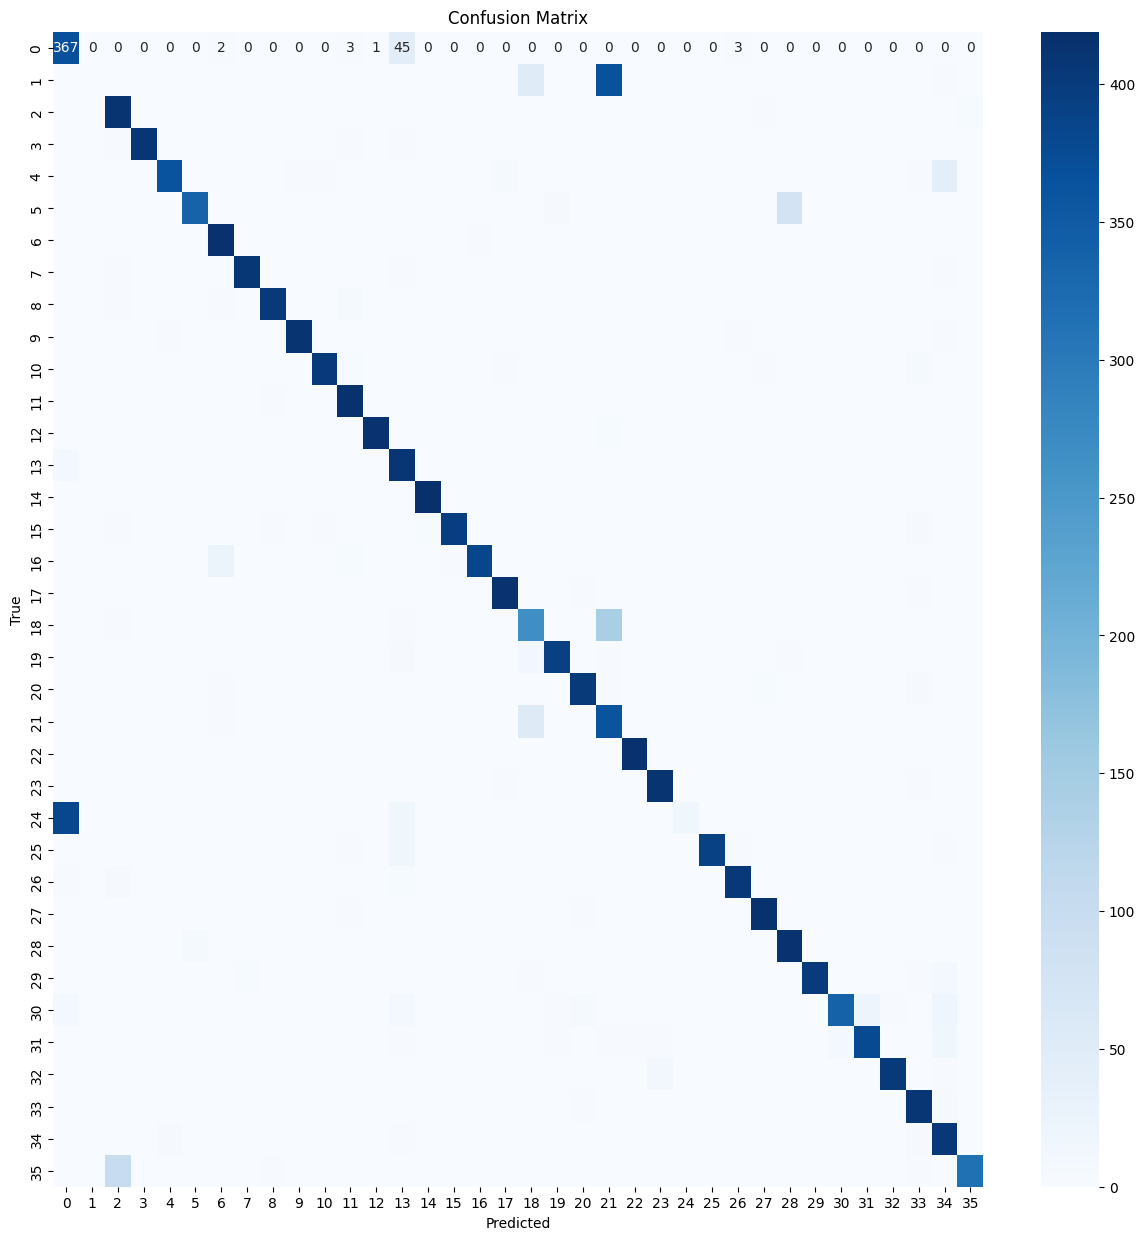

In [ ]:
# Visualizing Confusion Matrix

cm_ac2 = confusion_matrix(true_values_ac2, pred_values_ac2)
plt.figure(figsize=(15,15))
sns.heatmap(cm_ac2, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

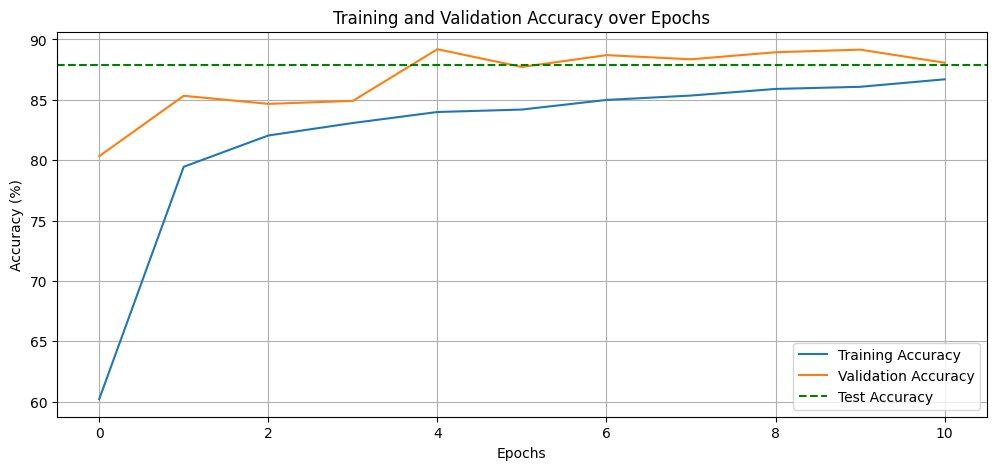

In [ ]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history_ac2, label='Training Accuracy')
plt.plot(val_accuracy_history_ac2, label='Validation Accuracy')
plt.axhline(y=(accuracy_ac2.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

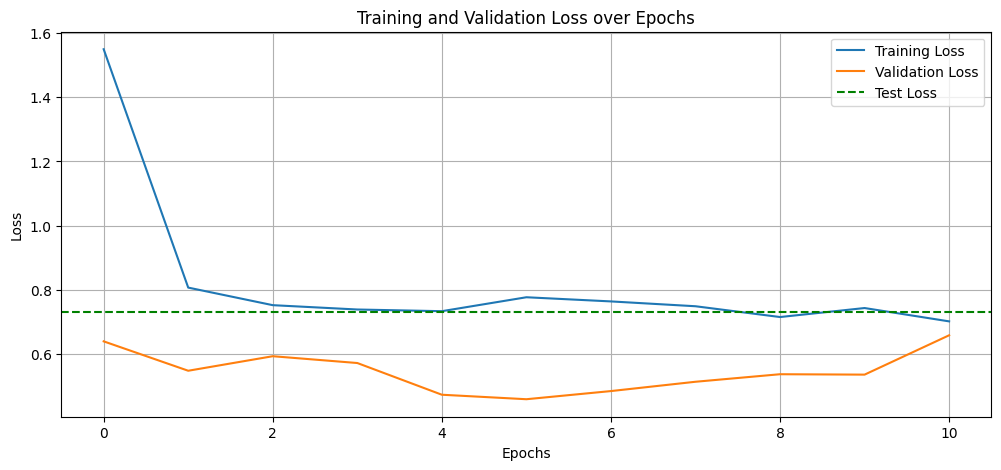

In [ ]:
# Losses Plot
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history_ac2, label='Training Loss')
plt.plot(val_loss_history_ac2, label='Validation Loss')
plt.axhline(y=test_loss_per_batch_ac2, color='g', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**sub-3(SELU)**

In [ ]:
# Initialize the model
cnn_ac3 = CNN(activation_function = nn.SELU()).to(device)
print(cnn_ac3)

# Model summary
summary(cnn_ac3, input_size=(3, 28, 28))

CNN(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): SELU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): SELU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): SELU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): SELU()
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5)

In [ ]:
# Selecting Cross Entropy Loss
criterion_ac3 = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer_ac3 = torch.optim.Adam(cnn_ac3.parameters(), lr=0.001)

In [ ]:
# Training and evaluating test and validation sets

train_accuracy_history_ac3, val_accuracy_history_ac3 = [], []
train_loss_history_ac3, val_loss_history_ac3 = [], []

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss_ac3 = float('inf')
no_improvement_count_ac3 = 0

# Start train time
start_train_time_ac3 = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    cnn_ac3.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer_ac3.zero_grad()
        outputs = cnn_ac3(images)
        loss = criterion_ac3(outputs, labels)
        loss.backward()
        optimizer_ac3.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    training_loss_per_batch_ac3 = running_loss / len(train_loader)
    train_loss_history_ac3.append(training_loss_per_batch_ac3)
    train_accuracy_history_ac3.append(100. * correct_train / total_train)

    cnn_ac3.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_ac3(images)
            val_loss += criterion_ac3(outputs, labels).item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    validation_loss_per_batch_ac3 = val_loss / len(val_loader)
    val_loss_history_ac3.append(validation_loss_per_batch_ac3)
    val_accuracy_history_ac3.append(100. * correct_val / total_val)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch_ac3}, Validation Loss: {validation_loss_per_batch_ac3}")

    # Early stopping
    if validation_loss_per_batch_ac3 < best_validation_loss_ac3:
        best_validation_loss_ac3 = validation_loss_per_batch_ac3
        no_improvement_count_ac3 = 0
    else:
        no_improvement_count_ac3 += 1
        if no_improvement_count_ac3 >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time_ac3 = time.time()
total_training_time_ac3 = end_train_time_ac3 - start_train_time_ac3

Loss for Epoch- 1: 
 Training Loss: 2.4819291151803116, Validation Loss: 0.8554908471072421
Loss for Epoch- 2: 
 Training Loss: 1.1524222665711452, Validation Loss: 0.5579729567491254
Loss for Epoch- 3: 
 Training Loss: 1.1430353231308896, Validation Loss: 0.8343777771913955
Loss for Epoch- 4: 
 Training Loss: 1.1731332770384808, Validation Loss: 0.7178291028877795
Loss for Epoch- 5: 
 Training Loss: 1.162232206326431, Validation Loss: 0.6288992421008929
Loss for Epoch- 6: 
 Training Loss: 1.167805726699085, Validation Loss: 0.786701180906125
Loss for Epoch- 7: 
 Training Loss: 1.2228332564315865, Validation Loss: 0.8153154432945767
Early stopping triggered after 7 epochs!


In [ ]:
# Printing the model weights

print(f"Model state: {cnn_ac3.state_dict()}")

Model state: OrderedDict([('conv1.weight', tensor([[[[-0.0328, -0.0612,  0.0863],
          [ 0.0182,  0.0355, -0.0976],
          [-0.0170,  0.1643, -0.0926]],

         [[-0.0626, -0.2143, -0.0357],
          [ 0.1130, -0.1308, -0.0803],
          [ 0.1934,  0.0185, -0.0377]],

         [[-0.1511, -0.1737, -0.1734],
          [-0.0609,  0.1314,  0.1050],
          [ 0.2399, -0.1096,  0.0936]]],


        [[[-0.0674,  0.1155, -0.0283],
          [ 0.1226, -0.2033, -0.1691],
          [ 0.0438, -0.1515,  0.1637]],

         [[ 0.1411,  0.1063, -0.0142],
          [ 0.0893, -0.1088,  0.1635],
          [ 0.0199, -0.2398,  0.2108]],

         [[ 0.0863, -0.0908, -0.1441],
          [ 0.0407,  0.0312, -0.1412],
          [ 0.0148, -0.0663, -0.0363]]],


        [[[-0.0857, -0.1781,  0.0341],
          [ 0.0149, -0.1997,  0.0947],
          [-0.0876, -0.1152, -0.1416]],

         [[-0.2039, -0.1057, -0.0817],
          [-0.1977, -0.0320, -0.2096],
          [ 0.0704, -0.1867, -0.0839]],

 

In [ ]:
# Evaluating test dataset
test_loss_ac3 = 0.0
total_test_ac3 = 0
pred_values_ac3 = []
true_values_ac3 = []
accuracy_ac3 = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_ac3(images)
        test_loss_ac3 += criterion_ac3(outputs, labels).item()
        _, predicted = outputs.max(1)
        total_test_ac3 += labels.size(0)

        accuracy_ac3(predicted, labels)

        # append predictions and true values
        pred_values_ac3.extend(predicted.cpu().numpy())
        true_values_ac3.extend(labels.cpu().numpy())

test_loss_per_batch_ac3 = test_loss_ac3 / len(test_loader)

In [ ]:
# calculate the evaluation metrices
precision_ac3 = precision_score(true_values_ac3, pred_values_ac3, average='macro')
recall_ac3 = recall_score(true_values_ac3, pred_values_ac3, average='macro')
f1_ac3 = f1_score(true_values_ac3, pred_values_ac3, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time_ac3:.4f} seconds")
print(f"Accuracy: {accuracy_ac3.compute():.4f}")
print(f"Precision: {precision_ac3:.4f}")
print(f"Recall: {recall_ac3:.4f}")
print(f"F1 Score: {f1_ac3:.4f}")

Time to train: 684.3640 seconds
Accuracy: 0.8604
Precision: 0.8817
Recall: 0.8604
F1 Score: 0.8594


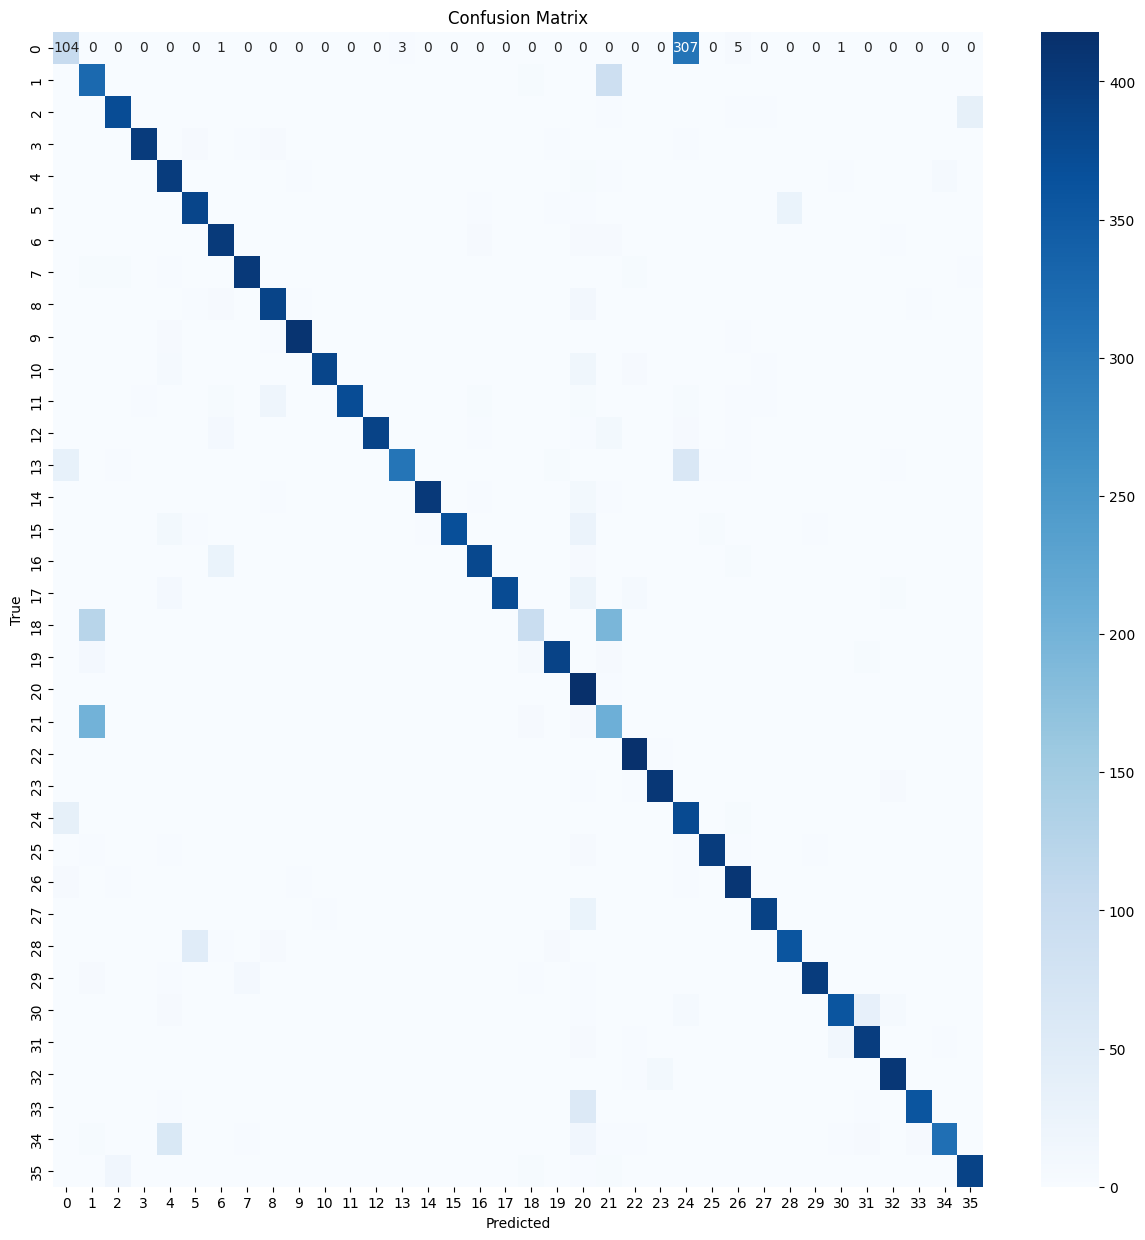

In [ ]:
# Visualizing Confusion Matrix

cm_ac3 = confusion_matrix(true_values_ac3, pred_values_ac3)
plt.figure(figsize=(15,15))
sns.heatmap(cm_ac3, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

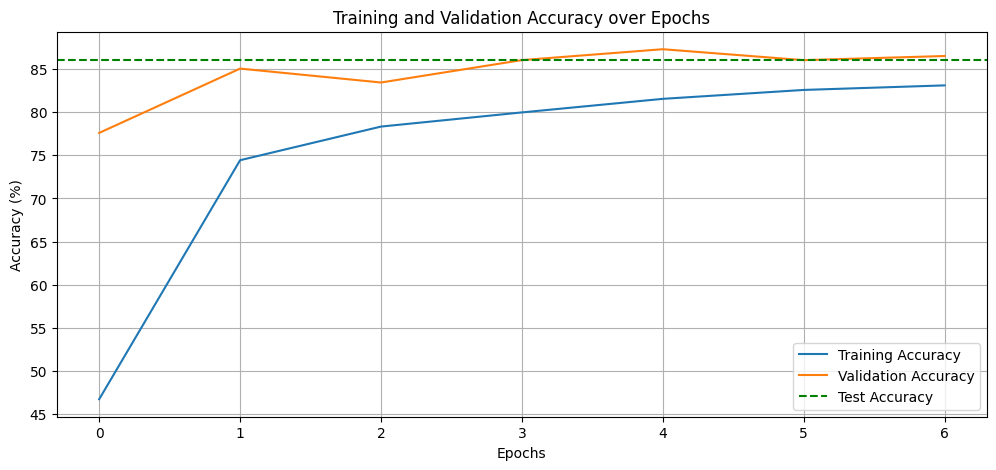

In [ ]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history_ac3, label='Training Accuracy')
plt.plot(val_accuracy_history_ac3, label='Validation Accuracy')
plt.axhline(y=(accuracy_ac3.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

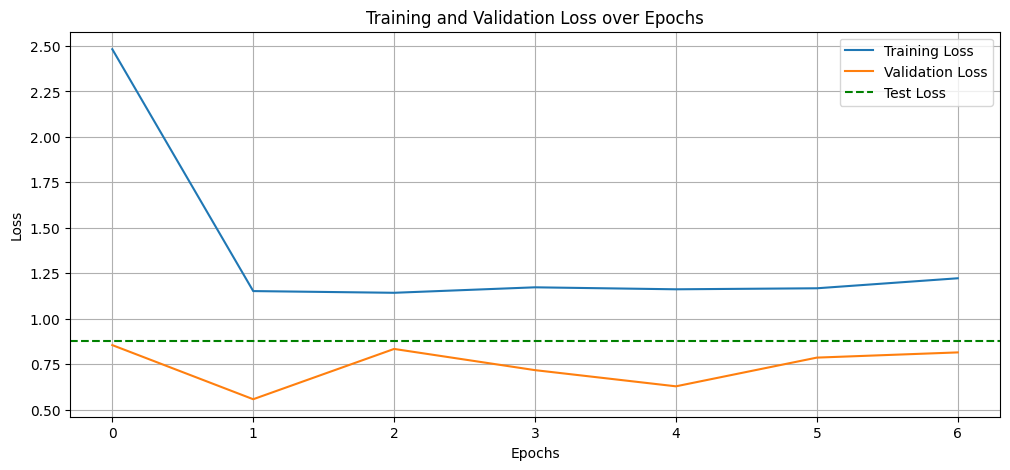

In [ ]:
# Losses Plot
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history_ac3, label='Training Loss')
plt.plot(val_loss_history_ac3, label='Validation Loss')
plt.axhline(y=test_loss_per_batch_ac3, color='g', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**VGG-11A**

In [8]:
# Reshape images

# Get train, test and validation image datasets
from torchvision.datasets import ImageFolder
import torch.utils.data
from torchvision import transforms

# Transform images to tensors
transform = transforms.Compose([
     transforms.Resize((80, 80)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Get image datasets and transform them to tensors
train_dataset = ImageFolder(data_path+'/train', transform=transform)
test_dataset = ImageFolder(data_path+'/test', transform=transform)
val_dataset = ImageFolder(data_path+'/val', transform=transform)

# Get the classes of dataset
classes = train_dataset.classes
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [9]:
# Load train, test and validation image datasets
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [21]:
# VGG-11 Version A architecture

class VGG11(nn.Module):
    def __init__(self, dp = 0.6, activation_function = nn.ReLU()):
        super().__init__()

        # Block-1
        '''
        Input will be 80*80*3
        output size of conv1 will be 80*80*64 since we are using padding
        '''
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = activation_function
        '''
        output size of maxpool-1 will be 40*40*64
        '''
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block-2
        '''
        Output of conv2 will still be 40*40*128
        '''
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = activation_function
        '''
        output of maxpool-2 will be 20*20*128
        '''
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block-3
        '''
        output of both conv layers will be 20*20*256
        '''
        self.conv3a = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu3a = activation_function
        self.conv3b = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.relu3b = activation_function
        '''
        output of maxpool-3 will be 10*10*256
        '''
        self.pool3  = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block-4
        '''
        output of both conv layers will be 10*10*512
        '''
        self.conv4a = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.relu4a = activation_function
        self.conv4b = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.relu4b = activation_function
        '''
        Output of maxpool-4 will be 5*5*512
        '''
        self.pool4  = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block-5
        '''
        output of both conv layers will be 5*5*512
        '''
        self.conv5a = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.relu5a = nn.ReLU()
        self.conv5b = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.relu5b = nn.ReLU()
        '''
        Output of maxpool-4 will be 2*2*512
        '''
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # FC-1
        self.fc1 = nn.Linear(512*2*2, 4096)
        self.relu6 = nn.ReLU()
        self.dropout1 = nn.Dropout(dp)

        # FC-2
        self.fc2 = nn.Linear(4096, 4096)
        self.relu7 = nn.ReLU()
        self.dropout2 = nn.Dropout(dp)

        # Output: 36 is the number of classes
        self.out = nn.Linear(4096, 36)

    def forward(self, x):

      # Block-1
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.pool1(x)

      # Block-2
      x = self.conv2(x)
      x = self.relu2(x)
      x = self.pool2(x)

      # Block-3
      x = self.conv3a(x)
      x = self.relu3a(x)
      x = self.conv3b(x)
      x = self.relu3b(x)
      x = self.pool3(x)

      # Block-4
      x = self.conv4a(x)
      x = self.relu4a(x)
      x = self.conv4b(x)
      x = self.relu4b(x)
      x = self.pool4(x)

      # Block-5
      x = self.conv5a(x)
      x = self.relu5a(x)
      x = self.conv5b(x)
      x = self.relu5b(x)
      x = self.pool5(x)

      # Flatten the output
      x = x.view(x.size(0), -1)

      # FC-1
      x = self.fc1(x)
      x = self.relu6(x)
      x = self.dropout1(x)

      # FC-2
      x = self.fc2(x)
      x = self.relu7(x)
      x = self.dropout2(x)

      # Output
      x = self.out(x)

      return x

In [22]:
# Instance of VGG-11

# Setting seed for reproducability
torch.manual_seed(42)

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device= {device}")

vgg = VGG11().to(device)
print(vgg)

Device= cuda
VGG11(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3a): ReLU()
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3b): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4a): ReLU()
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4b): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5a): Conv2d(512, 512, kernel_size=(3, 3), s

In [23]:
# Model summary
summary(vgg, input_size=(3, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           1,792
              ReLU-2           [-1, 64, 80, 80]               0
         MaxPool2d-3           [-1, 64, 40, 40]               0
            Conv2d-4          [-1, 128, 40, 40]          73,856
              ReLU-5          [-1, 128, 40, 40]               0
         MaxPool2d-6          [-1, 128, 20, 20]               0
            Conv2d-7          [-1, 256, 20, 20]         295,168
              ReLU-8          [-1, 256, 20, 20]               0
            Conv2d-9          [-1, 256, 20, 20]         590,080
             ReLU-10          [-1, 256, 20, 20]               0
        MaxPool2d-11          [-1, 256, 10, 10]               0
           Conv2d-12          [-1, 512, 10, 10]       1,180,160
             ReLU-13          [-1, 512, 10, 10]               0
           Conv2d-14          [-1, 512,

In [24]:
# Selecting Cross Entropy Loss
criterion_vgg = nn.CrossEntropyLoss()

# Selecting Adam for optimization
optimizer_vgg = torch.optim.Adam(vgg.parameters(), lr=0.001)

In [25]:
# Training and evaluating test and validation sets

train_accuracy_history_vgg, val_accuracy_history_vgg = [], []
train_loss_history_vgg, val_loss_history_vgg = [], []

# Initialize best_validation_loss and no_improvement_count for early stopping
best_validation_loss_vgg = float('inf')
no_improvement_count_vgg = 0

# Start train time
start_train_time_vgg = time.time()

# Training Loop
epochs = 100
for epoch in range(epochs):
    vgg.train()
    running_loss_vgg = 0.0
    correct_train_vgg = 0
    total_train_vgg = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer_vgg.zero_grad()
        outputs = vgg(images)
        loss_vgg = criterion_vgg(outputs, labels)
        loss_vgg.backward()
        optimizer_vgg.step()
        running_loss_vgg += loss_vgg.item()
        _, predicted_vgg = outputs.max(1)
        total_train_vgg += labels.size(0)
        correct_train_vgg += predicted_vgg.eq(labels).sum().item()

    training_loss_per_batch_vgg = running_loss_vgg / len(train_loader)
    train_loss_history_vgg.append(training_loss_per_batch_vgg)
    train_accuracy_history_vgg.append(100. * correct_train_vgg / total_train_vgg)

    vgg.eval()
    val_loss_vgg = 0.0
    correct_val_vgg = 0
    total_val_vgg = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg(images)
            val_loss_vgg += criterion_vgg(outputs, labels).item()
            _, predicted_vgg = outputs.max(1)
            total_val_vgg += labels.size(0)
            correct_val_vgg += predicted_vgg.eq(labels).sum().item()

    validation_loss_per_batch_vgg = val_loss_vgg / len(val_loader)
    val_loss_history_vgg.append(validation_loss_per_batch_vgg)
    val_accuracy_history_vgg.append(100. * correct_val_vgg / total_val_vgg)

    # Printing the loss
    print(f"Loss for Epoch- {epoch + 1}: \n Training Loss: {training_loss_per_batch_vgg}, Validation Loss: {validation_loss_per_batch_vgg}")

    # Early stopping
    if validation_loss_per_batch_vgg < best_validation_loss_vgg:
        best_validation_loss_vgg = validation_loss_per_batch_vgg
        no_improvement_count_vgg = 0
    else:
        no_improvement_count_vgg += 1
        if no_improvement_count_vgg >= 5:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

# end_train_time
end_train_time_vgg = time.time()
total_training_time_vgg = end_train_time_vgg - start_train_time_vgg

Loss for Epoch- 1: 
 Training Loss: 3.140877815426586, Validation Loss: 1.1091222194563441
Loss for Epoch- 2: 
 Training Loss: 0.5729784868698155, Validation Loss: 0.32106350390475336
Loss for Epoch- 3: 
 Training Loss: 0.3240264153713107, Validation Loss: 0.28207931086174487
Loss for Epoch- 4: 
 Training Loss: 0.28081794162897794, Validation Loss: 0.27057808560921864
Loss for Epoch- 5: 
 Training Loss: 0.2543124027834181, Validation Loss: 0.24869993562661424
Loss for Epoch- 6: 
 Training Loss: 0.24677262353810556, Validation Loss: 0.2606219362603019
Loss for Epoch- 7: 
 Training Loss: 0.22561503016472728, Validation Loss: 0.24753694948368557
Loss for Epoch- 8: 
 Training Loss: 0.2113761763931835, Validation Loss: 0.24554378443843677
Loss for Epoch- 9: 
 Training Loss: 0.20903309014120466, Validation Loss: 0.25557212671613516
Loss for Epoch- 10: 
 Training Loss: 0.199569575731962, Validation Loss: 0.2547052363853338
Loss for Epoch- 11: 
 Training Loss: 0.18973224500562663, Validation L

In [26]:
# Saving the model weights

print(f"Model state: {vgg.state_dict()}")
torch.save(vgg.state_dict(), 'vgg11.h5')

Model state: OrderedDict([('conv1.weight', tensor([[[[ 0.1326,  0.1351, -0.0849],
          [ 0.1666, -0.0677, -0.0034],
          [-0.1026,  0.0876,  0.1245]],

         [[-0.1558,  0.1426, -0.0038],
          [ 0.1320,  0.0006,  0.0506],
          [-0.0361,  0.1230, -0.0167]],

         [[-0.1044,  0.0244, -0.1284],
          [-0.0328, -0.1036,  0.0854],
          [-0.1609, -0.1141, -0.0995]]],


        [[[-0.1118,  0.0284, -0.1729],
          [ 0.1655, -0.1679,  0.1503],
          [ 0.0076, -0.0861,  0.0978]],

         [[ 0.0339,  0.1658,  0.0383],
          [-0.0690,  0.0473, -0.0505],
          [ 0.0566,  0.1482,  0.0901]],

         [[-0.0802,  0.1214,  0.0517],
          [ 0.0894, -0.1217, -0.1888],
          [-0.0988, -0.1713,  0.1368]]],


        [[[ 0.0604,  0.0882,  0.0795],
          [-0.0080,  0.1525, -0.1246],
          [-0.0061, -0.1408,  0.0610]],

         [[-0.0613,  0.0674, -0.0214],
          [ 0.1550, -0.1122, -0.1027],
          [-0.1330,  0.1637,  0.0658]],

 

In [27]:
# Evaluating test dataset
test_loss_vgg = 0.0
correct_test_vgg = 0
total_test_vgg = 0
pred_values_vgg = []
true_values_vgg = []
accuracy_vgg = Accuracy(task="multiclass", num_classes=36).to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        test_loss_vgg += criterion_vgg(outputs, labels).item()
        _, predicted_vgg = outputs.max(1)
        total_test_vgg += labels.size(0)

        accuracy_vgg(predicted_vgg, labels)

        # append predictions and true values
        pred_values_vgg.extend(predicted_vgg.cpu().numpy())
        true_values_vgg.extend(labels.cpu().numpy())

test_loss_per_batch_vgg = test_loss_vgg / len(test_loader)

In [28]:
# calculate the evaluation metrices
precision_vgg = precision_score(true_values_vgg, pred_values_vgg, average='macro')
recall_vgg = recall_score(true_values_vgg, pred_values_vgg, average='macro')
f1_vgg = f1_score(true_values_vgg, pred_values_vgg, average='macro')

# Printing evaluation metrices:
print(f"Time to train: {total_training_time_vgg:.4f} seconds")
print(f"Accuracy: {accuracy_vgg.compute():.4f}")
print(f"Precision: {precision_vgg:.4f}")
print(f"Recall: {recall_vgg:.4f}")
print(f"F1 Score: {f1_vgg:.4f}")

Time to train: 1154.7311 seconds
Accuracy: 0.9105
Precision: 0.9119
Recall: 0.9105
F1 Score: 0.9103


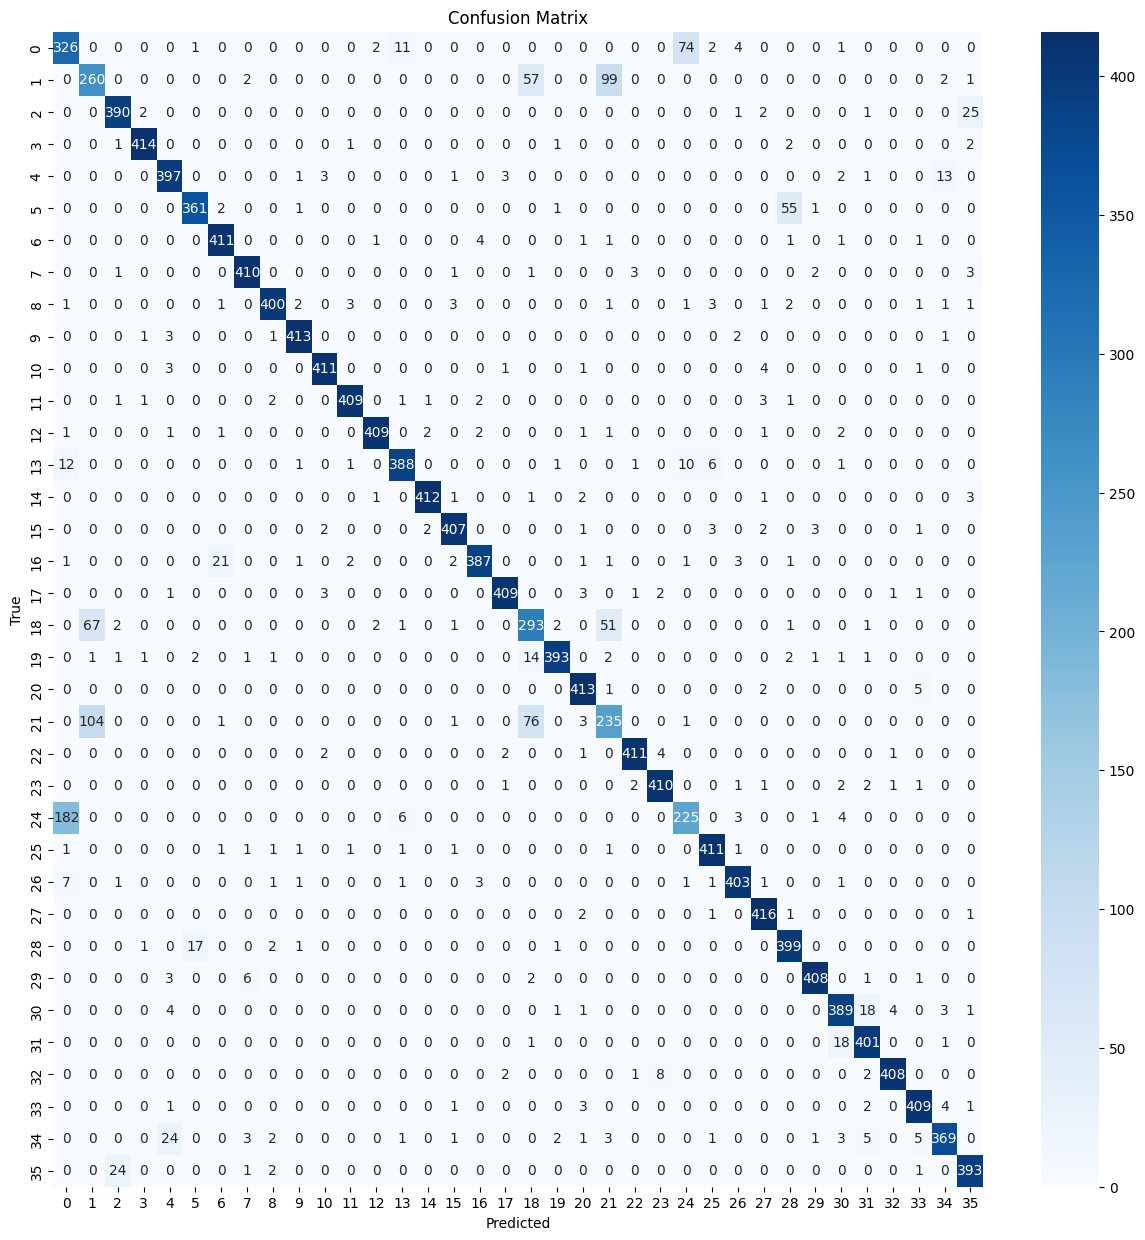

In [31]:
# Visualizing Confusion Matrix

cm_vgg = confusion_matrix(true_values_vgg, pred_values_vgg)
plt.figure(figsize=(15,15))
sns.heatmap(cm_vgg, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

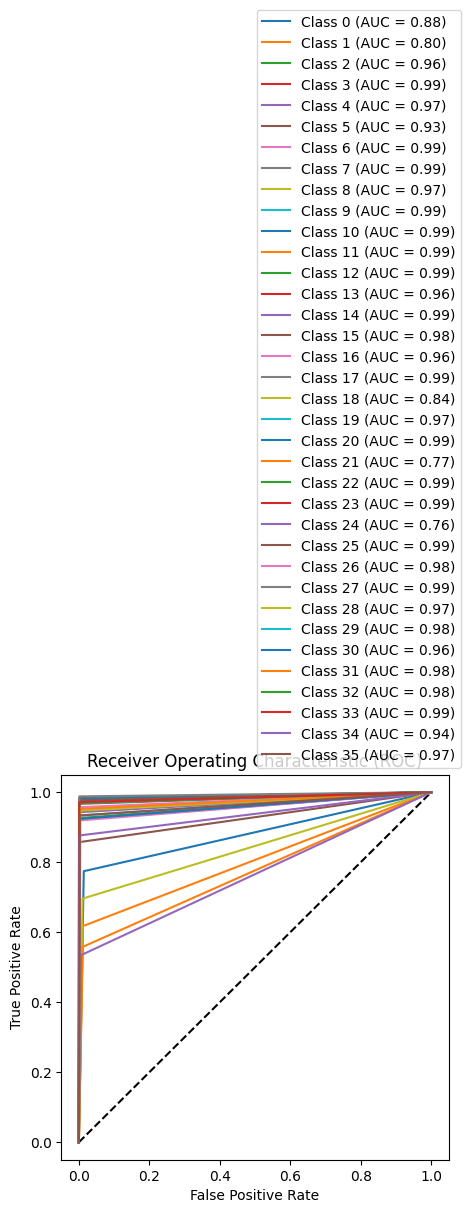

In [33]:
# ROC curve

fpr_vgg = dict()
tpr_vgg = dict()
roc_auc_vgg = dict()

# Convert to one-hot encoded format
true_one_hot_vgg = np.eye(36)[true_values_vgg]
predicted_one_hot_vgg = np.eye(36)[pred_values_vgg]

for i in range(36):
    fpr_vgg[i], tpr_vgg[i], _ = roc_curve(true_one_hot_vgg[:, i], predicted_one_hot_vgg[:, i])
    roc_auc_vgg[i] = auc(fpr_vgg[i], tpr_vgg[i])


plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(36):
    plt.plot(fpr_vgg[i], tpr_vgg[i], label=f'Class {i} (AUC = {roc_auc_vgg[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 1))
plt.show()

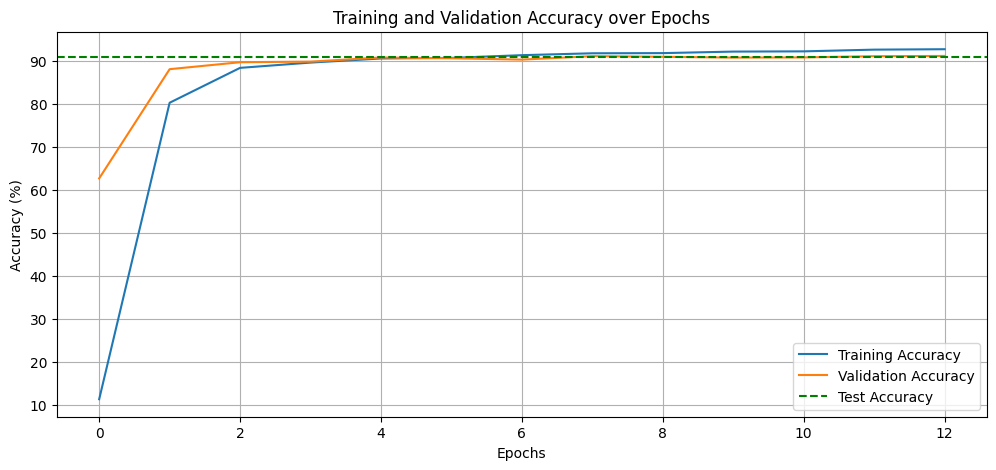

In [34]:
# Accuracies Plot
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy_history_vgg, label='Training Accuracy')
plt.plot(val_accuracy_history_vgg, label='Validation Accuracy')
plt.axhline(y=(accuracy_vgg.cpu().compute()) * 100, color='g', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

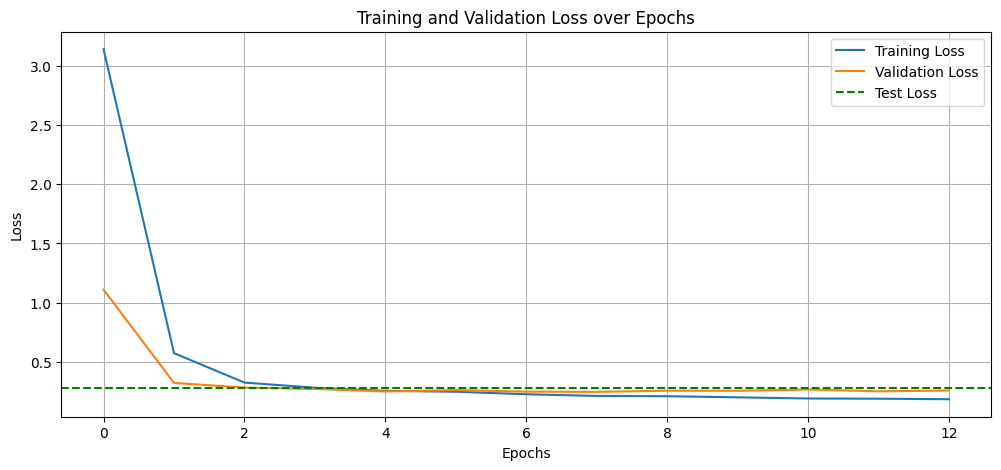

In [35]:
# Losses Plot
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history_vgg, label='Training Loss')
plt.plot(val_loss_history_vgg, label='Validation Loss')
plt.axhline(y=test_loss_per_batch_vgg, color='g', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
'''
References:
1. ROC curve: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
2. Note: Most of the code has been resued from part-2 of this assignment.
3. Alexnet: https://en.wikipedia.org/wiki/AlexNet
4. VGG11: Lecture notes
'''

'\nReferences:\n1. ROC curve: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html\n2. Note: Most of the code has been resued from part-2 of this assignment.\n3. Alexnet: https://en.wikipedia.org/wiki/AlexNet\n4. VGG11: Lecture notes\n'